# Stock Price Forecasting

Conventional time series forecasting models have been widely used to construct predictions, such as the ARIMA models. Nevertheless, such models can perform quite poorly on financial data since financial markets are regarded as non-linear dynamic systems.

So, we introduce recurrent neural networks (RNNs) that can learn complex dimensionality of the financial time series, which is essential to improving prediction performance. 

However, neural networks have a problem choosing parameters for the model, and solely the user's experience mostly determines them. To cope with this problem, metaheuristic optimization is considered such as particle swarm optimization, genetic algorithm, and so forth.

The purpose of this notebook is to construct GA-optimized RNNs, namely LSTM and GRU networks, and compare their performance to the ARIMA model's forecast used as a benchmark. 

In addition, we want to test whether technical indicators are helpful for financial time series forecasting as additional features, as a RNN architecture allows us to use a multivariate time series. 

## Getting Started

Install `sktime` package to work with ARIMA models and reload the notebook.

In [ ]:
pip install sktime[all_extras]

Download necessary libraries:

In [48]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})
    
rcParams['figure.figsize'] = 10, 8

theme_bw = 'theme_bw.mplstyle'
plt.style.use(theme_bw)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [62]:
from genetic_algorithm import *

import pandas as pd

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Load the data.

In [43]:
import datetime as dt

# Use https://github.com/pydata/pandas-datareader/issues/868 to overcome the issue with pandas_datareader
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

The Standard and Poor's 500, or simply the S\&P 500, index is considered to compare the ARIMA as a benchmark model with metaheuristically optimized RNNs.

In [44]:
ticker = "SPY"
df = pdr.get_data_yahoo(ticker, dt.datetime(2000, 1,1,1), dt.datetime(2021, 1,1))

[*********************100%***********************]  1 of 1 completed


Let us look at the time series.

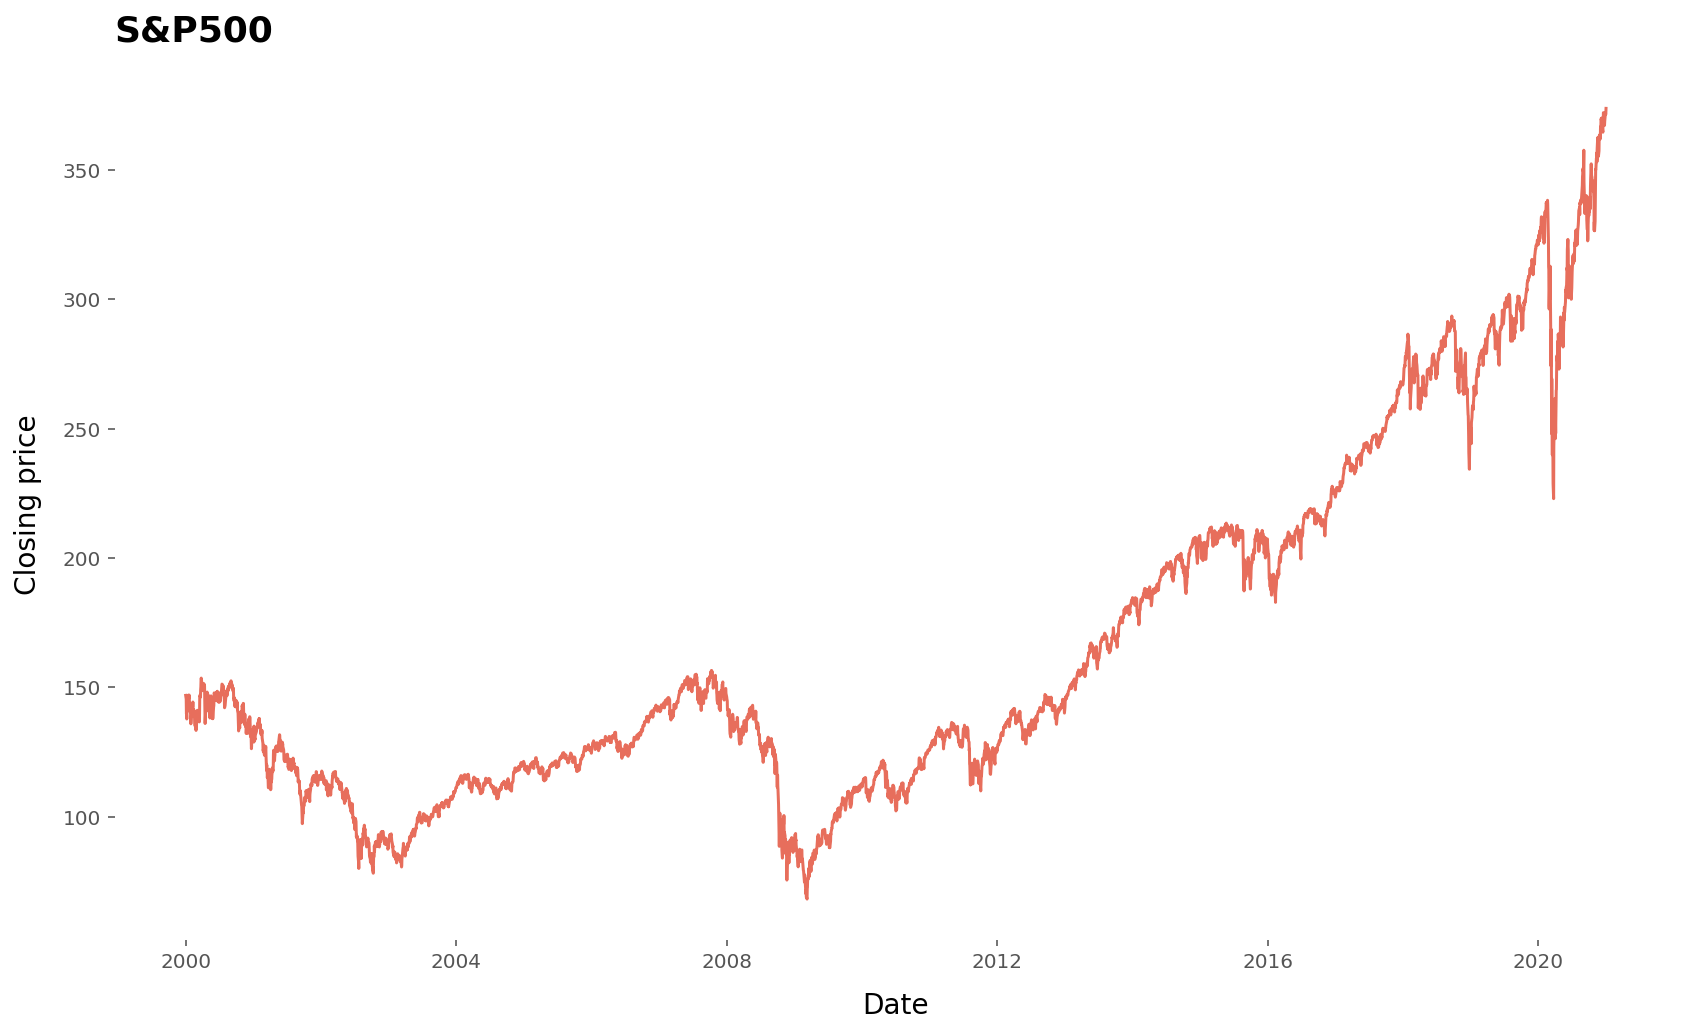

In [49]:
plt.figure(figsize=(14, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')
plt.plot(df.index, df['Close'], alpha=0.8)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.grid(False);

In [50]:
del df['Adj Close']

The research data for the index forecasting comes from 1 January 2000 to 1 January 2021 and is obtained from Yahoo Finance. Thus, an entire dataset has 5284 samples, or trading dates, in the form of daily closing prices. For the ARIMA model, we purely divide the dataset into training (90\%) and test (10\%) sets, while for globally optimized RNNs, we also separate the validation set (25\%) from the training set in order to correctly choose the hyperparameters $\Theta_{\text{RNN}}$.


In [51]:
train_size = round(0.9 * df.shape[0])
test_size = df.shape[0] - train_size
val_size = round(0.25 * train_size)
train_size = train_size - val_size

In [52]:
y_train = df['Close'][:val_size + train_size - 1]
y_test = df['Close'][val_size + train_size - 1:]

Several objective functions to measure forecast accuracy are used in the notebook, namely

$
\begin{equation*} 
\begin{aligned}
\text{RMSE}(\hat y, X) = & \ \sqrt{\frac{1}{T}\sum\limits _{t=1}^{T}( y_{t} -\hat{y}( x_{t} ; w))^{2}} \\
\text{MAE}(\hat{y}, X) = & \ \frac{1}{T}\sum\limits _{t=1}^{T} |y_{t} -\hat{y}( x_{t} ; w)| \\
\text{SMAPE}(\hat{y}, X) = & \ \frac{1}{T}\sum _{t=1}^{T}\dfrac{|y_{t} -\hat{y}( x_{t} ; w) |}{( |y_{t} |+|\hat{y}(x_{t};  w) |) /2} \ 
\end{aligned}
\end{equation*} 
$

and also one performance metric is used

$$
R^{2}\left(\hat{y}, X\right) =1-\frac{\sum\limits _{t=1}^{T}( y_{t} -\hat{y}(x_{t} ; w))^{2}}{\sum\limits _{t=1}^{T}( y_{t} -\overline{y})^{2}} ,\ \overline{y} =\frac{1}{T}\sum\limits _{t=1}^{T} y_{t}
$$

## ARIMA

In [53]:
import statsmodels.api as sm

Autoregressive integrated moving average, or ARIMA, model is the most widely used approach to time series forecasting. It attempts to capture the linear relationship between response variable $\displaystyle y_{t}$ and its lagged values $y_{t-1}, \dots, y_{t-k}$, that is information available earlier.

If a series $\{y_t\}_{t=1}^T$ is assumed to be non-stationary, but a series $\{\Delta^d y_t\}_{t=1}^T$, on the contrary, is stationary, we use $\text{ARIMA}(p, d, q)$ process for $y_t$ with $d$-order of difference:
$
\begin{equation*}
\begin{aligned}
\Delta ^{d} y_{t} = & \ \alpha +\sum _{i=1}^{p} \varphi _{i} \Delta ^{d} y_{t-i} +\sum _{i=1}^{q} \psi _{i} \varepsilon _{t-i} +\varepsilon _{t} \\
\left( 1-\sum _{i=1}^{p} \varphi _{i} L^{i}\right) \Delta ^{d}y_{t} = & \ \alpha +\left( 1+\sum _{i=1}^{q} \psi _{i} L^{i}\right) \varepsilon _{t} \\
\varphi _{p}( L) \Delta ^{d}y_{t} = & \ \alpha +\psi _{q}( L) \varepsilon _{t}
\end{aligned}
\end{equation*}
$

For this section, the Box-Jenkins methodology is used to construct the ARIMA model. At the first stage, we use a Box-Cox transformation to stabilize the variance of the series with $\lambda = 0$:
$$
    \tilde{y}_{t} ={\displaystyle \begin{cases}
    \ln y_{t} & \lambda =0\\
    \dfrac{y_{t}^{\lambda } -1}{\lambda } , & \lambda \neq 0
    \end{cases}}
$$
where $y_t$ is a closing price of S\&P500 index at time step $t$.

In [54]:
df_new = df.copy()

In [55]:
df_new['Log_Close'] = np.log(df_new['Close'])

Then we identify whether our time series is stationary or not with the autocorrelation (ACF) and partial autocorrelation (PACF) functions. The former measures the linear relationship between the value of the index at the time step $t$ with that of lagged value at the time step $t-k$:

$$
\hat{\rho }_{k} =\widehat{\mathbb{Corr}}[y_{t}, y_{t-k}] =\dfrac{\sum\limits _{t=k+1}^{T}(y_{t} -\overline{y})(y_{t-k} -\overline{y})}{\sqrt{\sum\limits _{t=k+1}^{T}(y_{t} -\overline{y})^{2}\sum\limits _{t=k+1}^{T}( y_{t-k} -\overline{y})^{2}}},\ \overline{y} =\dfrac{1}{T}\sum _{t=1}^{T} y_{t},\ 0\leqslant k\leqslant T-1 
$$

Whereas the latter is a <<pure>> correlation, noted $\beta _{k}$, that can be obtained from the $\text{AR(k)}$ process:

$$
y_{t} =\beta _{0} + \beta_{1} y_{t-1} +  \dots + \beta _{k} y_{t-k} +\varepsilon _{t}
$$

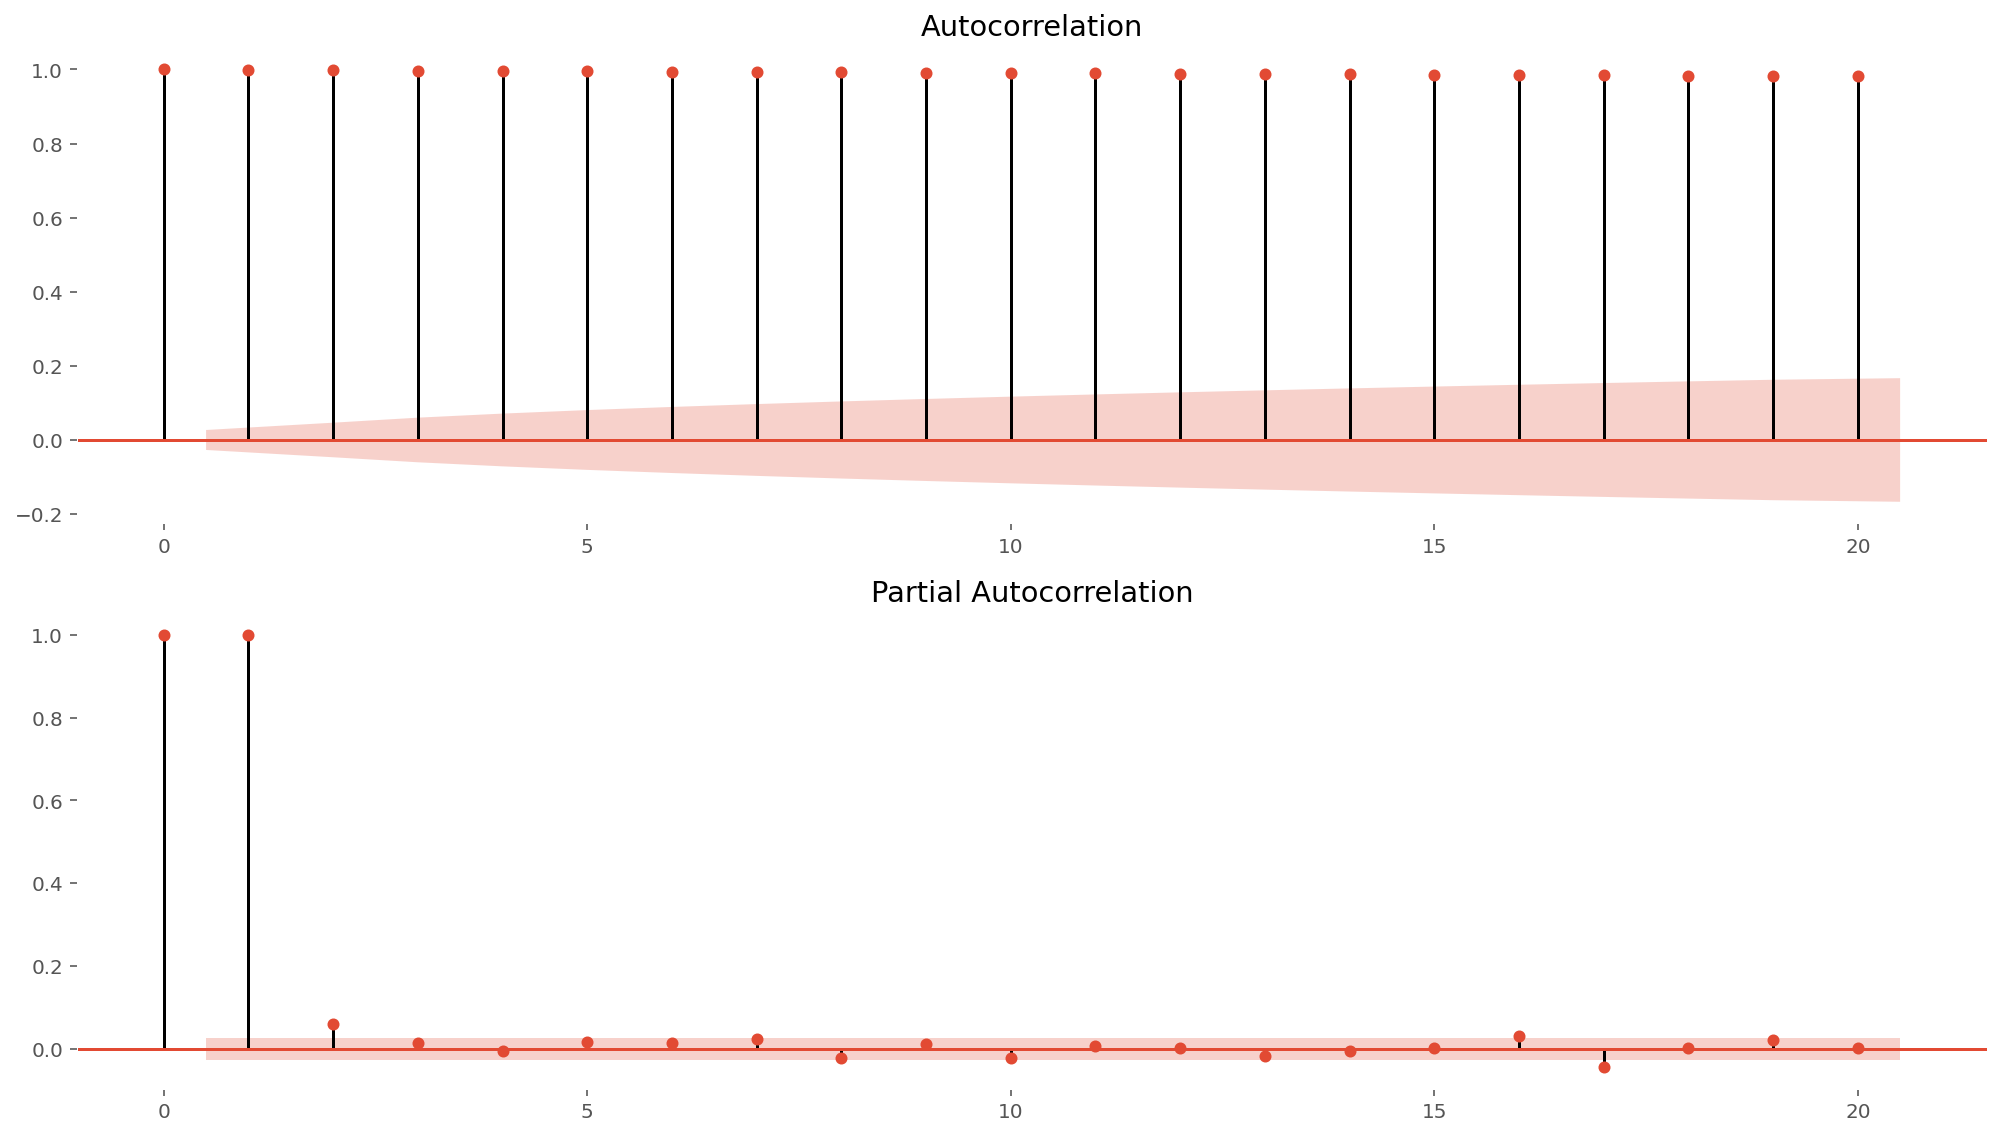

In [56]:
fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_new['Log_Close'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
ax1.grid(False);
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_new['Log_Close'], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
ax2.grid(False)
fig.tight_layout();

As we can observe, the time series is clearly not stationary. Hence, we conclude that differencing is required and use a first-order difference, $\Delta y_t = y_t - y_{t-1}$.

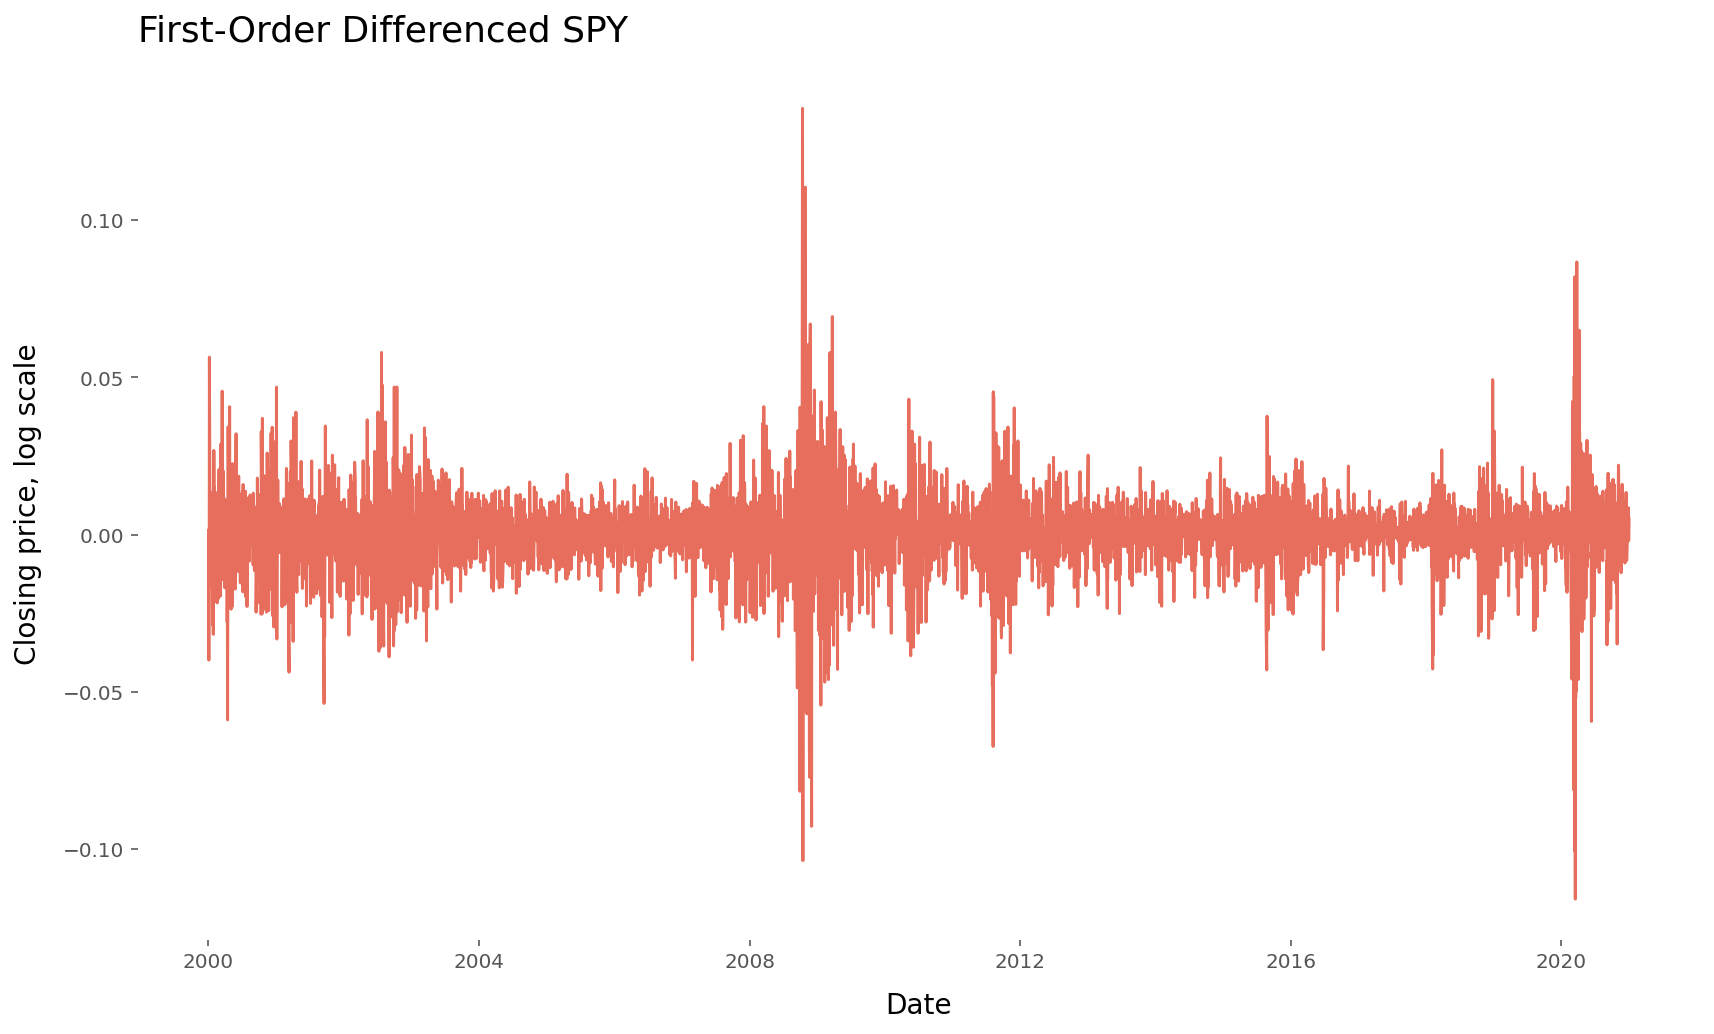

In [57]:
df_new['Log_Close_Shift_1'] = df_new['Log_Close'].shift()
df_new["Log_Close_Diff_1"] = df_new['Log_Close'] - df_new['Log_Close_Shift_1']
df_new_a = df_new.dropna()

plt.figure(figsize=(14, 8))
plt.title(f'First-Order Differenced {ticker}', pad=14, fontsize=18, loc='left')
plt.plot(df_new_a.index, df_new_a['Log_Close_Diff_1'], alpha=0.8)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price, log scale', labelpad=10, fontsize=14)
plt.grid(False);

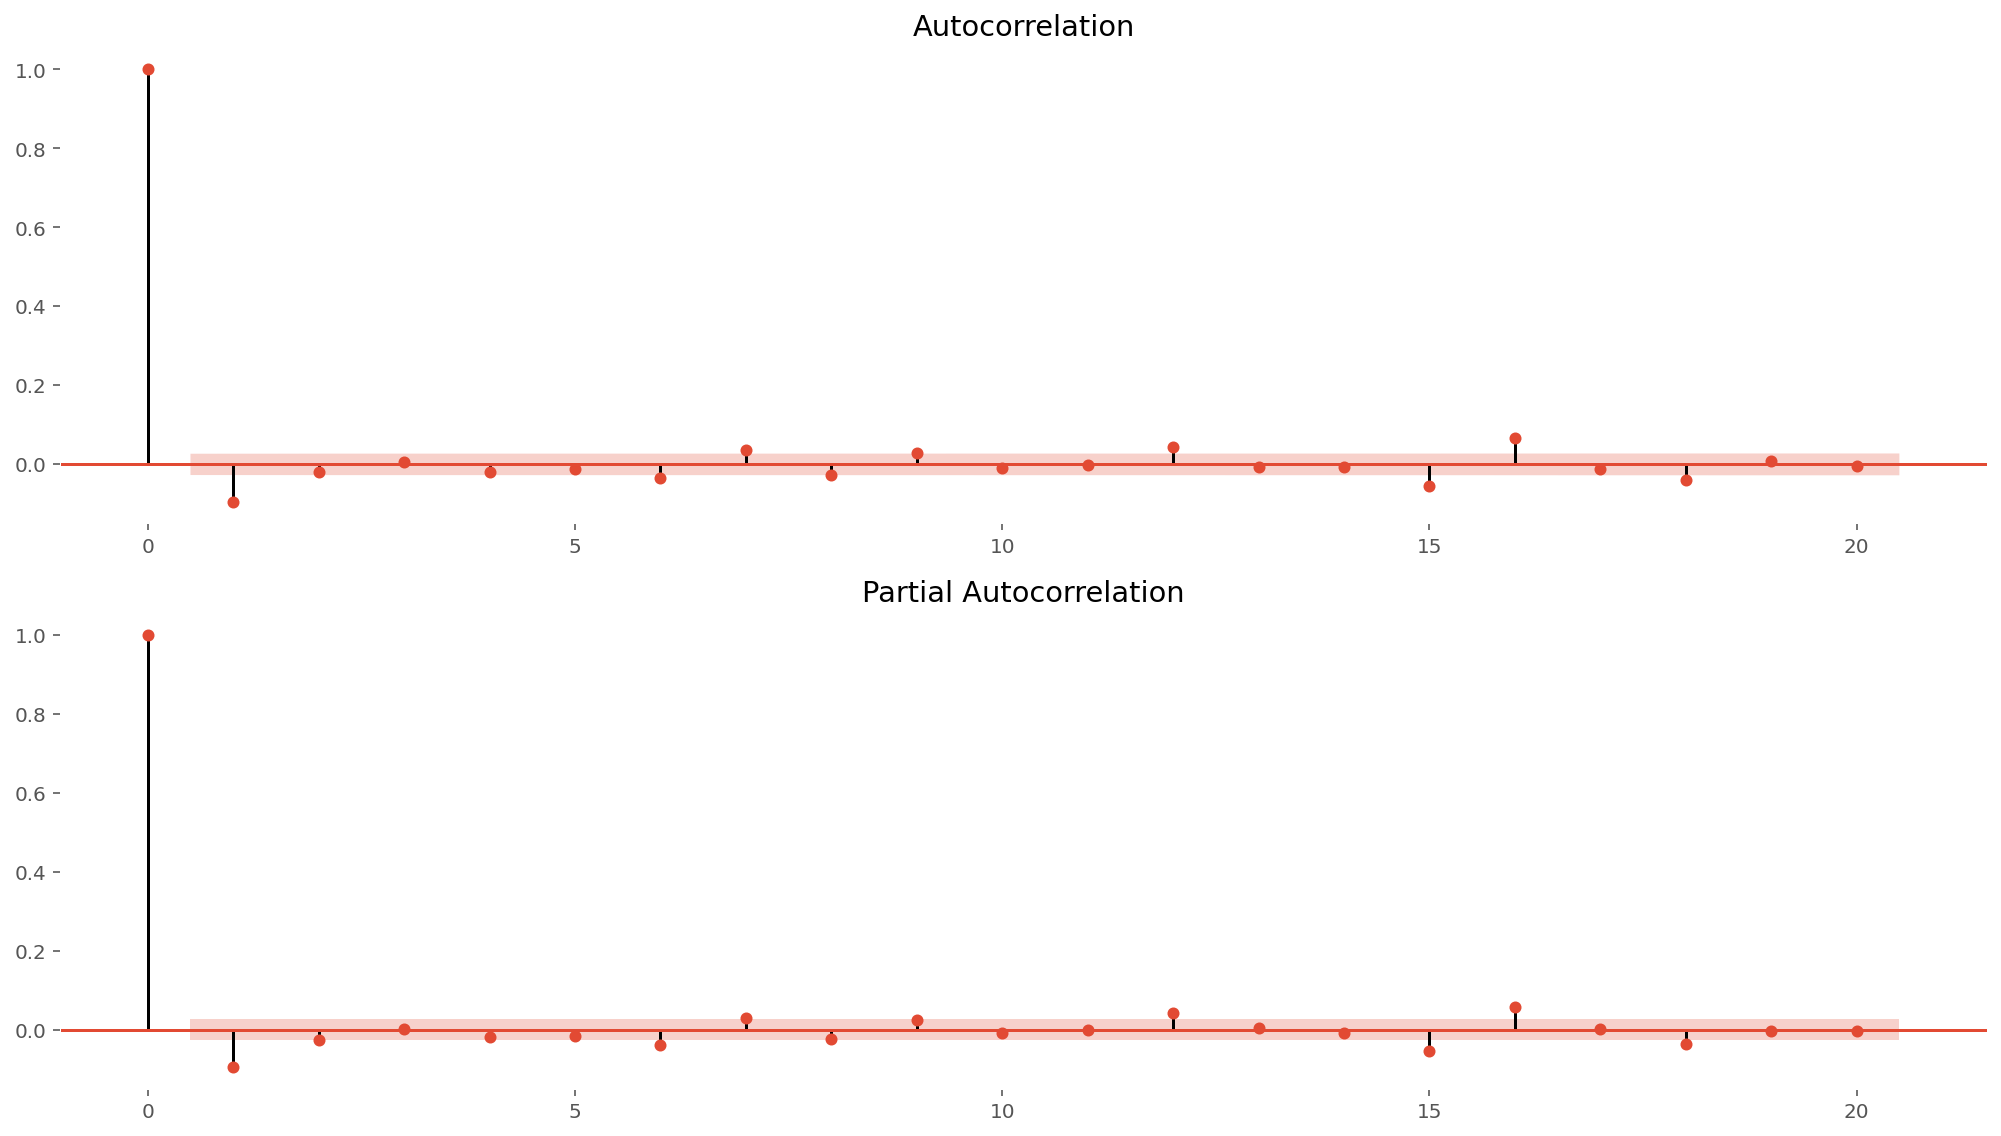

In [58]:
fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_new_a['Log_Close_Diff_1'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
ax1.grid(False)
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_new_a['Log_Close_Diff_1'], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
ax2.grid(False)
fig.tight_layout();

After using differencing, it can easily be noted that the time series $\{\Delta y_t\}_{t=1}^T$ appears to be stationary both in its mean and variance. 

Nevertheless, to determine more objectively whether additional differencing is required, an augmented Dickey-Fuller (ADF) test is used, which is a part of unit root tests. Our null hypothesis is that the time series is non-stationary, while the alternative hypothesis that it is stationary.

In [59]:
from statsmodels.tsa.stattools import adfuller

In [60]:
result = adfuller(df_new_a['Log_Close_Diff_1'])
print(f'ADF Statistic: {result[0]:.6}')
print(f'p-value: {result[1]:.3}')
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.5015
p-value: 2.97e-25
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


For our data, the ADF statistic is $-13.507$ and its p-value is $2.9\mathrm{e}$-$25$. Thus, we fail to accept the null hypothesis and conclude that the series is stationary.

This allows us to choose a number of $p$ AR and $q$ MA lags for the ARIMA model. For that we examine the stationary first-order differenced time
series and propose several models. The best model is then chosen by the Akaike (AIC), corrected Akaike (AICc), and Bayes (BIC) information criteria:

$
\begin{equation*} 
\begin{aligned}
\text{AIC} = & \ 2n - 2\ln\mathcal{L} \\
\text{AICc} = & \ AIC+\dfrac{2n( 1+n)}{T-s-n-1} \\ 
\text{BIC} = & \ n\ln( T-s) -2\ln\mathcal{L}, \ s=\max(p_{max}, q_{max}) \\ 
\end{aligned}
\end{equation*} 
$

where $n$ is a number of model parameters and $\mathcal{L}$ is likelihood.

However, in our case, we just can use the automatic ARIMA implemented in Python, which itself selects the correct number of lags by minimizing the above-noted information criteria.

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

In [ ]:
auto_arima = AutoARIMA(start_p=1, d=1, start_q=0, 
                       max_p=10, max_d=2, max_q=10, 
                       start_P=0, D=0, start_Q=0, 
                       max_P=0, max_D=0, max_Q=0, 
                       suppress_warnings=True, 
                       stepwise=False, n_jobs=-1)

In [ ]:
train_ts_2 = pd.Series(data=y_train.values, index=pd.PeriodIndex(y_train.index, freq='D'))
auto_arima.fit(train_ts_2);

In [ ]:
test_ts_2 = pd.Series(data=y_test.values, index=pd.PeriodIndex(y_test.index, freq='D'))
fh = ForecastingHorizon(test_ts_2.index, is_relative=False)

If we assume the first-order differencing, $\Delta y_{t} =y_{t} -y_{t-1}$, then the point forecast for the ARIMA(p, 1, q) model is
$
\begin{equation*}
\begin{aligned}
\Delta \hat y_t = & \ \hat \alpha + \hat \varphi_{1}\Delta y_{t-1} + \dots + \hat \varphi_{p}\Delta y_{t-p} + \varepsilon _{t} + \hat \psi_1 \varepsilon _{t-1} + \dots + \hat \psi_q \varepsilon_{t-q} \\
\hat y_t = & \ \hat \alpha + (\hat\varphi_1 + 1)y_{t-1} - (\hat\varphi_1 - \hat\varphi_2)y_{t-2} - \dots - (\hat\varphi_{p-1} - \hat\varphi_p)y_{t-p} - \hat \varphi_p y_{t-p-1} + \\
 & \ \ \ + \varepsilon _{t} + \hat \psi_1 \varepsilon _{t-1} + \dots + \hat \psi_q \varepsilon_{t-q}
\end{aligned}
\end{equation*}
$

Then $95$-\% forcast interval is 
$$
\left(\hat y_t - 1.96\sqrt{\mathbb{Var}(\hat y_t)}, \hat y_t + 1.96\sqrt{\mathbb{Var}(\hat y_t)} \right)
$$

In [ ]:
y_pred, y_intervals = auto_arima.predict(fh, return_pred_int=True)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'{ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index[:train_size+val_size], df['Close'][:train_size+val_size], 
         label='Train', alpha=0.8)

plt.plot(df.index[train_size+val_size:], df['Close'][train_size+val_size:], 
         label='Test', alpha=0.8)

ci_upper = y_intervals['upper'] - y_pred
ci_lower = y_pred - y_intervals['lower']

plt.plot(df.index[train_size+val_size:], y_pred, label='Pred', color='orange', alpha=0.8)

plt.fill_between(df.index[train_size+val_size:], (y_pred-ci_lower), (y_pred+ci_upper), color='orange', alpha=0.1)

plt.grid(False)

plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

In [63]:
from sklearn.metrics import r2_score

In [ ]:
print(f'Test RMSE = {np.sqrt(sum((y_pred.values - y_test.values) ** 2)):.6}')
print(f'Test MAE = {sum(np.abs(y_pred.values - y_test.values)):.6}')
smape_test = 100 / len(y_pred.values) * np.sum(2 * np.abs(y_pred.values - y_test.values) / (np.abs(y_pred.values) + np.abs(y_test.values)))
print(f'Test SMAPE = {smape_test:.4}')
print(f'Test R_sq = {r2_score(y_test.values, y_pred.values):.2}')

In the end, to assure that our model is adequate, we investigate if a series of the forecast errors can be considered as a white noise. To check that, the Ljung-Box test is used, where the null hypothesis assumes there is no remaining residual autocorrelation at lags 1 to $k$, while the alternative hypothesis assumes that at least one of the autocorelations is non-zero:

$$
\begin{cases}
H_{0} : & \rho _{1} =\dotsc =\rho _{k} =0\\
H_{a} : & \exists \rho _{i} \neq 0, \ i \in \{1, \dots, k\}
\end{cases}
$$

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
residuals = y_test.values - y_pred.values
acorr_ljungbox(residuals, lags=10, return_df=True)

The Ljung-Box statistic has the form of $Q_{obs} = T(T+2)\sum_{s=1}^{k}\dfrac{\hat{\rho }_{s}^{2}}{T-s}  \stackrel{H_0}{\sim} \chi ^{2}( k)$, where $k$ is a number of lags being tested. For our data, considering 10 lags the Ljung-Box statistic is equal to $4354.6$ with p-value of $0$. Thus, the null hypothesis is rejected and we assume that there is a significant residual autocorrelation. Hence, our model is not fully adequate, and a different model should be considered.

We can conclude that the ARIMA model has no significant performance. Hence, the GA-optimized recurrent network, or simply GA-RNN, with 14 look-back periods is proposed.

## Feature Engineering

Given the RNN architecture, we can add additional features into our dataset, namely trading volume for the S\&P500 index and its technical indicators, such as 14-day simple and weighted moving averages, 200-day exponential moving average, relative strength index, and bollinger bands. So, we consider models: (GA-)LSTM and (GA-)GRU that take only a series of closing prices as an input, plus (GA-)LSTM-TI and (GA-)GRU-TI that take a multivariate series with technical indicators.

In [64]:
import technical_indicators as ti

In [65]:
df['SMA(10)'] = ti.simple_moving_average(df, 10)
df['WMA(10)'] = ti.weighted_moving_average(df, 10)
df['EMA(200)'] = ti.weighted_moving_average(df, 10)

In [66]:
rsi = ti.relative_strength_index(df, 14)

#k_percent, d_percent = ti.stochastic_oscillator(df)
low_bb, high_bb = ti.bollinger_bands(df)
macd, macd_signal, macd_difference = ti.moving_average_convergence_divergence(df)

In [67]:
df['Above_SMA(10)'] = np.where(df['Close'] > df['SMA(10)'], 1, 0)
df['Above_WMA(10)'] = np.where(df['Close'] > df['WMA(10)'], 1, 0)
df['Above_EMA(200)'] = np.where(df['Close'] > df['EMA(200)'], 1, 0)

df['Oversold_RSI(14)'] = np.where(rsi < 30, 1, 0)
df['Overbought_RSI(14)'] = np.where(rsi > 70, 1, 0)
df['Oversold_Bollinger'] = np.where(df['Close'] < low_bb, 1, 0)
df['Overbought_Bollinger'] = np.where(df['Close'] > high_bb, 1, 0)

In [68]:
df.dropna(inplace=True)

In [69]:
df.head()

,Open,High,Low,Close,Volume,SMA(10),WMA(10),EMA(200),Above_SMA(10),Above_WMA(10),Above_EMA(200),Oversold_RSI(14),Overbought_RSI(14),Oversold_Bollinger,Overbought_Bollinger
Date,,,,,,,,,,,,,,,
2000-01-13,144.46875,145.75000,143.28125,145.00000,5158300,143.437500,143.592045,143.592045,1,1,1,0,0,0,0
2000-01-14,146.53125,147.46875,145.96875,146.96875,7437300,143.446875,144.234091,144.234091,1,1,1,0,0,0,0
2000-01-18,145.34375,146.62500,145.18750,145.81250,6488500,143.484375,144.664205,144.664205,1,1,1,0,0,0,0
2000-01-19,145.31250,147.00000,145.00000,147.00000,6157900,144.209375,145.303409,145.303409,1,1,1,0,0,0,0
2000-01-20,146.96875,146.96875,143.81250,144.75000,5800100,144.684375,145.401705,145.401705,1,0,0,0,0,0,0


In [70]:
df.describe()

,Open,High,Low,Close,Volume,SMA(10),WMA(10),EMA(200),Above_SMA(10),Above_WMA(10),Above_EMA(200),Oversold_RSI(14),Overbought_RSI(14),Oversold_Bollinger,Overbought_Bollinger
count,5276.000000,5276.000000,5276.000000,5276.000000,5.276000e+03,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000
mean,165.484699,166.463891,164.409138,165.485628,1.117991e+08,165.291382,165.355929,165.355929,0.590788,0.586619,0.586619,0.018006,0.058946,0.068802,0.062737
std,67.253436,67.480339,66.991729,67.258000,9.743367e+07,66.947338,67.042163,67.042163,0.491735,0.492487,0.492487,0.132986,0.235546,0.253141,0.242512
min,67.949997,70.000000,67.099998,68.110001,1.436600e+06,71.247000,70.557818,70.557818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,116.672501,117.477503,115.657503,116.587498,4.881275e+07,116.487500,116.397363,116.397363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,138.693748,139.665939,137.699997,138.642502,8.247435e+07,138.871500,138.781908,138.781908,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,207.220005,208.232498,206.027504,207.332497,1.486664e+08,206.988499,207.017135,207.017135,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,373.809998,378.459991,371.570007,373.880005,8.710263e+08,370.258997,370.883089,370.883089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In addition to that, we introduce dummy variables that are considered to be buy and sell signals. They are supposed to help the (GA-)RNN-TI models predict the right closing price movement. Let $i \in \{\text{SMA}, \text{WMA}, \text{EMA}\}$ and $j \in \{\text{RSI}, \text{BB}\}$, then  dummy variables can be written as

$$
\begin{equation*} 
\begin{aligned}
D^{\text{below}}_{it} = & \  {\displaystyle \begin{cases}
    1, &  \text{closing price is below $n$-day indicator $i$ at time $t$ }\\
    0, & \text{otherwise} 
    \end{cases}}\\
D^{\text{above}}_{it} = & \ {\displaystyle \begin{cases}
    1, &  \text{closing price is above $n$-day indicator $i$ at time $t$ }\\
    0, & \text{otherwise} 
    \end{cases}}\\
D^{\text{oversold}}_{jt} = & \  {\displaystyle \begin{cases}
1, &  \text{$n$-day indicator $j$ at time $t$ is lower than $30$}\\
0, & \text{otherwise} 
\end{cases}}  \\
D^{\text{overbought}}_{jt} = & \  {\displaystyle \begin{cases}
    1, &  \text{$n$-day indicator $j$ at time $t$ is greater than $70$}\\
    0, & \text{otherwise} 
    \end{cases}}  \\
\end{aligned}
\end{equation*} 
$$

The indicator variables $D^{\text{oversold}}_{jt}$ and $D^{\text{overbought}}_{jt}$ are depicted below.

In [71]:
buy_signal_rsi = np.where(df['Oversold_RSI(14)'].to_numpy() == 1, df['Close'], np.nan)
sell_signal_rsi = np.where(df['Overbought_RSI(14)'].to_numpy() == 1, df['Close'], np.nan)

buy_signal_bb = np.where(df['Oversold_Bollinger'].to_numpy() == 1, df['Close'], np.nan)
sell_signal_bb = np.where(df['Overbought_Bollinger'].to_numpy() == 1, df['Close'], np.nan)

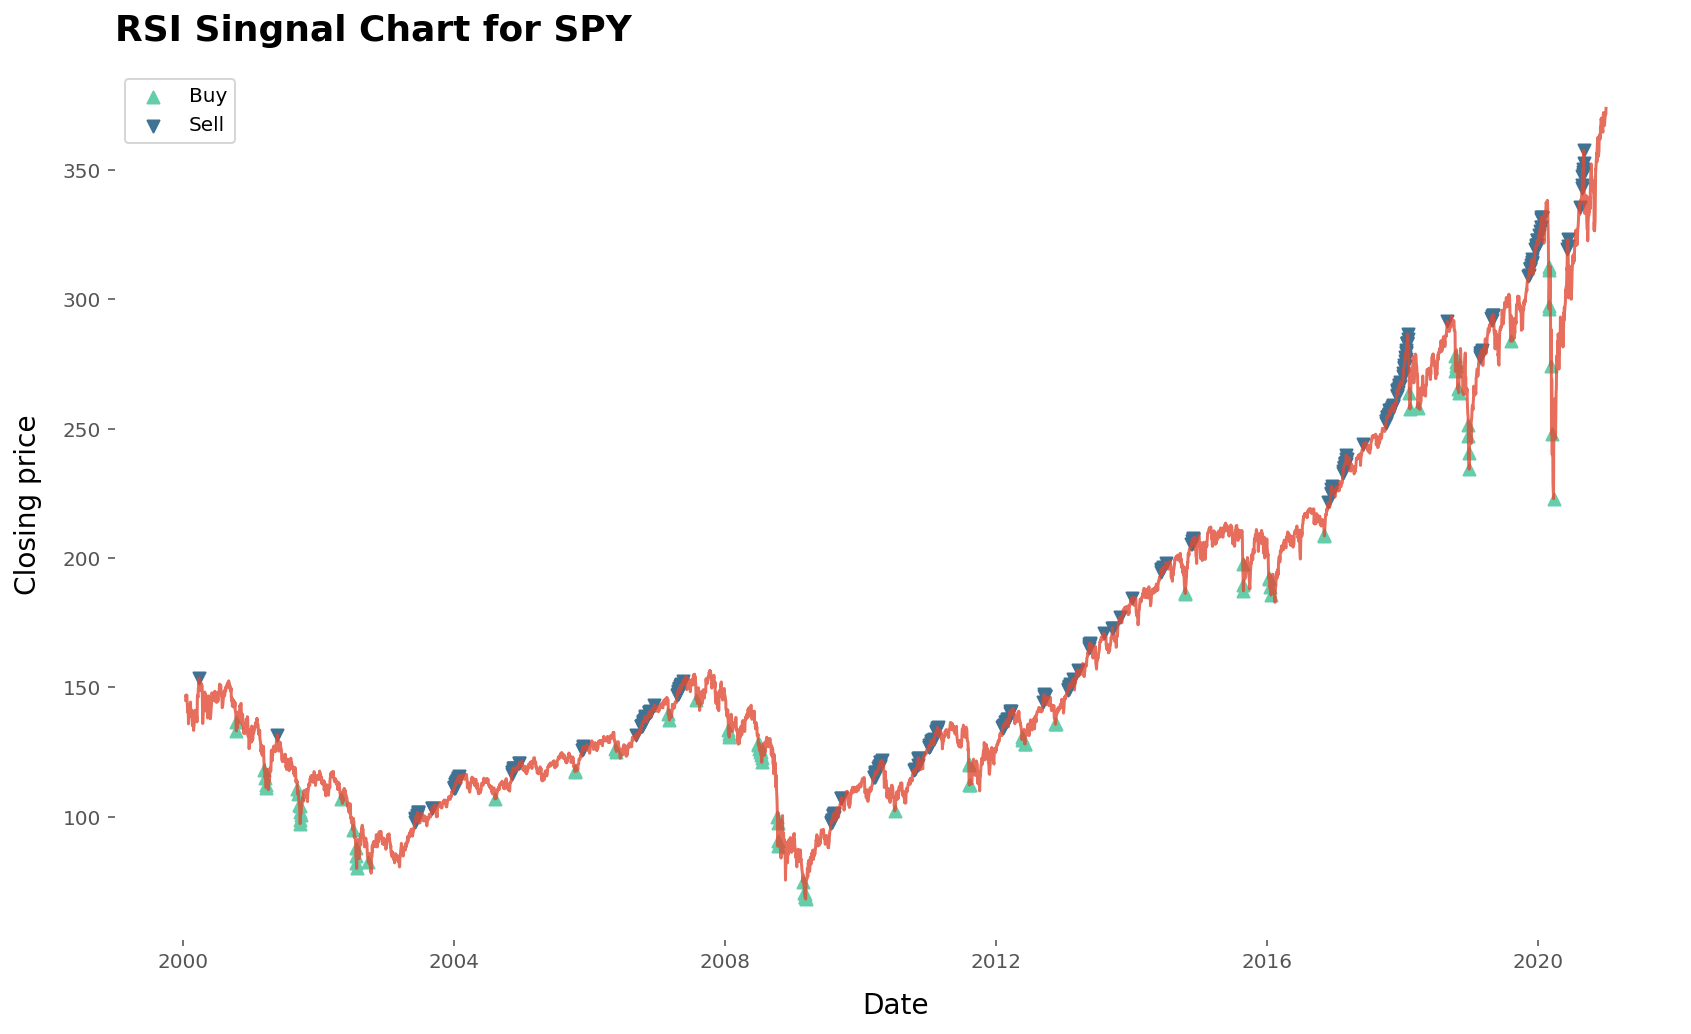

In [72]:
plt.figure(figsize=(14, 8))
plt.title(f'RSI Singnal Chart for {ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], alpha=0.8)
plt.scatter(df.index, buy_signal_rsi, label='Buy', marker='^', color='#66cdaa')
plt.scatter(df.index, sell_signal_rsi, label='Sell', marker='v', color='#407294')

plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.grid(False)
plt.legend();

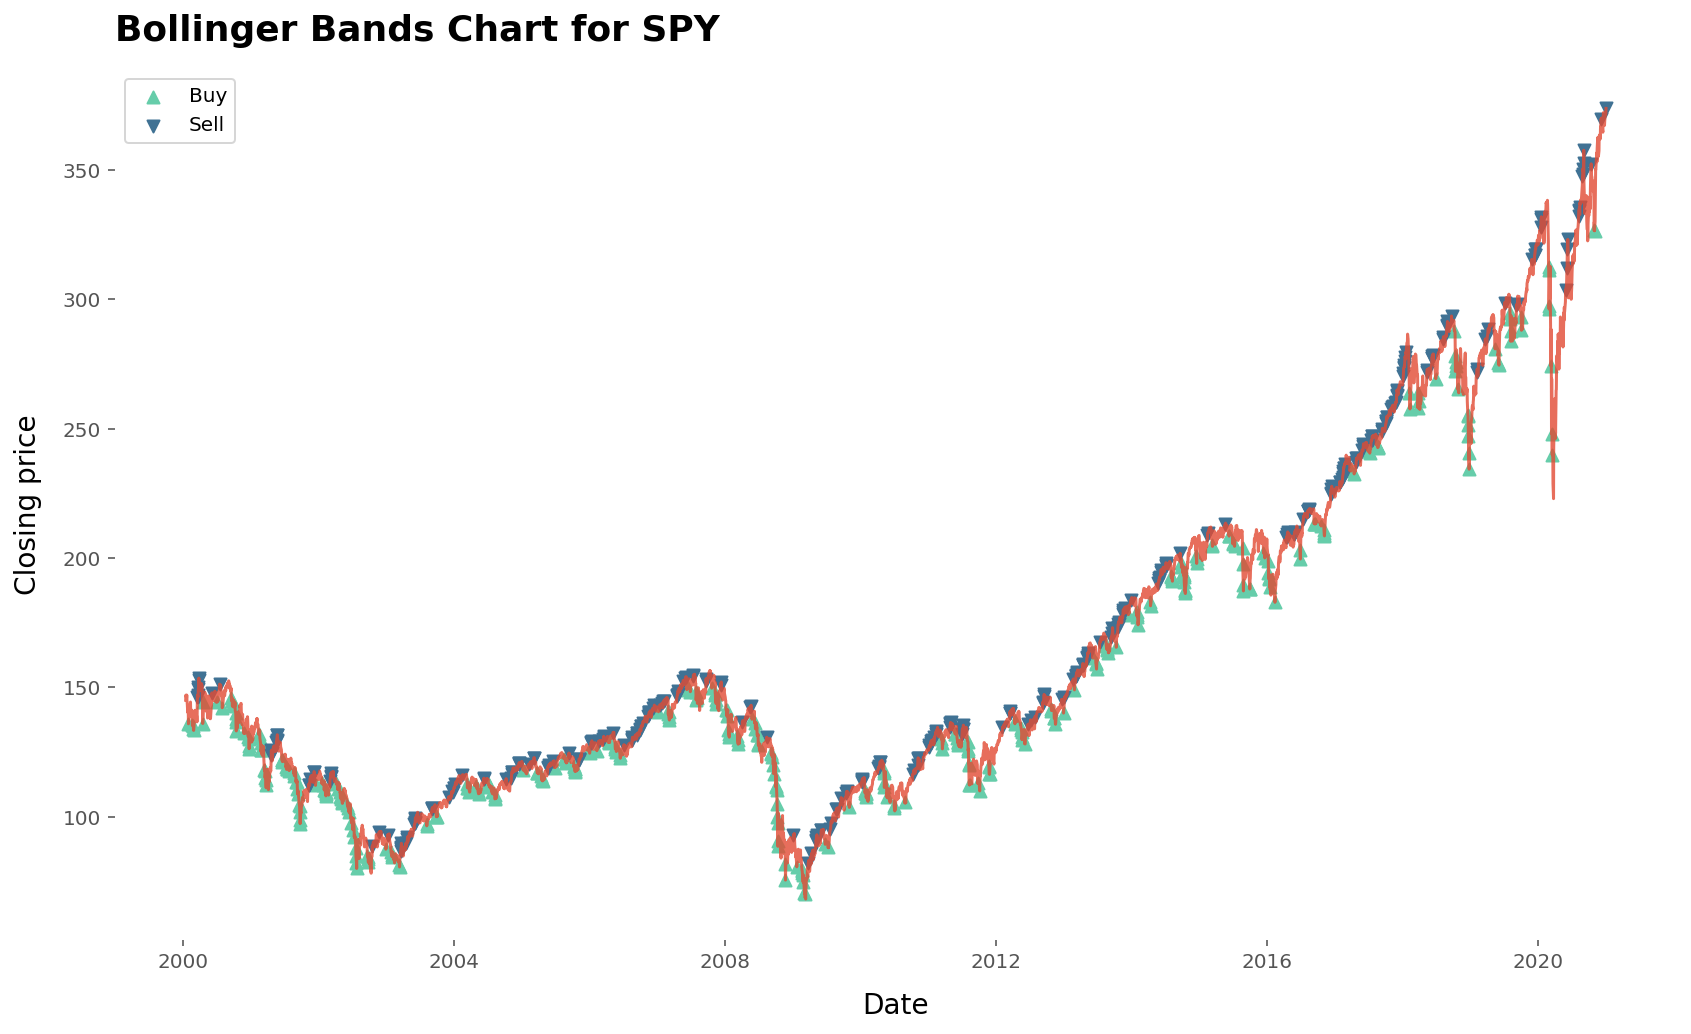

In [73]:
plt.figure(figsize=(14, 8))
plt.title(f'Bollinger Bands Chart for {ticker}', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], alpha=0.8)
plt.scatter(df.index, buy_signal_bb, label='Buy', marker='^', color='#66cdaa')
plt.scatter(df.index, sell_signal_bb, label='Sell', marker='v', color='#407294')

plt.grid(False)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14)
plt.legend();

## Preprocess Data

Split the data on training, validation and test datasets to work with RNNs.

### Without Technical Indicators

In [74]:
train_size = round(0.9 * df.shape[0])
test_size = df.shape[0] - train_size
val_size = round(0.25 * train_size)
train_size = train_size - val_size

In [75]:
data = df['Close'].to_numpy()

After creating dummy variables, the time-series are min-max normalized, such that the preprocessed data lies between zero and one:

$$
    \tilde{x}_{tj} = \dfrac{x_{tj}-\min_tx_{tj}}{\max_tx_{tj}-\min_tx_{tj}}
$$


In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler_without = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_without.fit_transform(data.reshape(-1, 1))).reshape(1, -1).type(torch.Tensor)

In [77]:
window_size = 15

batch_windows = data_preproc.unfold(dimension=-1, size=window_size, step=1).reshape(-1, window_size, 1)
    
X_train_without = batch_windows[:val_size + train_size, :-1, :]
X_test_without = batch_windows[val_size + train_size:, :-1]

# Need predict the next value considering 14 lookback periods
y_train_without = batch_windows[:val_size + train_size, -1, :]
y_test_without = batch_windows[val_size + train_size:, -1, :]

### With Technical Indicators

In [78]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA(10)', 'WMA(10)',
       'EMA(200)', 'Above_SMA(10)', 'Above_WMA(10)', 'Above_EMA(200)',
       'Oversold_RSI(14)', 'Overbought_RSI(14)', 'Oversold_Bollinger',
       'Overbought_Bollinger'],
      dtype='object')

In [79]:
columns_titles = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA(10)', 'WMA(10)',
                  'EMA(200)', 'Oversold_RSI(14)', 'Overbought_RSI(14)',
                  'Oversold_Bollinger', 'Overbought_Bollinger']
df=df.reindex(columns=columns_titles)

In [80]:
df.head()

,Close,High,Low,Open,Volume,SMA(10),WMA(10),EMA(200),Oversold_RSI(14),Overbought_RSI(14),Oversold_Bollinger,Overbought_Bollinger
Date,,,,,,,,,,,,
2000-01-13,145.00000,145.75000,143.28125,144.46875,5158300,143.437500,143.592045,143.592045,0,0,0,0
2000-01-14,146.96875,147.46875,145.96875,146.53125,7437300,143.446875,144.234091,144.234091,0,0,0,0
2000-01-18,145.81250,146.62500,145.18750,145.34375,6488500,143.484375,144.664205,144.664205,0,0,0,0
2000-01-19,147.00000,147.00000,145.00000,145.31250,6157900,144.209375,145.303409,145.303409,0,0,0,0
2000-01-20,144.75000,146.96875,143.81250,146.96875,5800100,144.684375,145.401705,145.401705,0,0,0,0


In [81]:
scaler_with = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_with.fit_transform(df)).type(torch.Tensor)

In [82]:
data_preproc_t = data_preproc.transpose(-2, -1)
data_preproc_t

tensor([[-0.4971, -0.4842, -0.4918,  ...,  0.9842,  0.9876,  1.0000],
        [-0.5089, -0.4977, -0.5032,  ...,  0.9711,  0.9652,  0.9754],
        [-0.4996, -0.4819, -0.4871,  ...,  0.9951,  1.0000,  0.9978],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000,  1.0000]])

In [83]:
windows = []

for i in range(data_preproc.shape[1]):
    windows.append(data_preproc_t.unfold(dimension=-1, size=window_size, step=1)[i].reshape(-1, window_size, 1))

In [84]:
batch_windows = torch.cat((windows), dim=2)

In [85]:
X_train_with = batch_windows[:val_size + train_size, :-1, :]
X_test_with = batch_windows[val_size + train_size:, :-1]

y_train_with = y_train_without
y_test_with = y_test_without

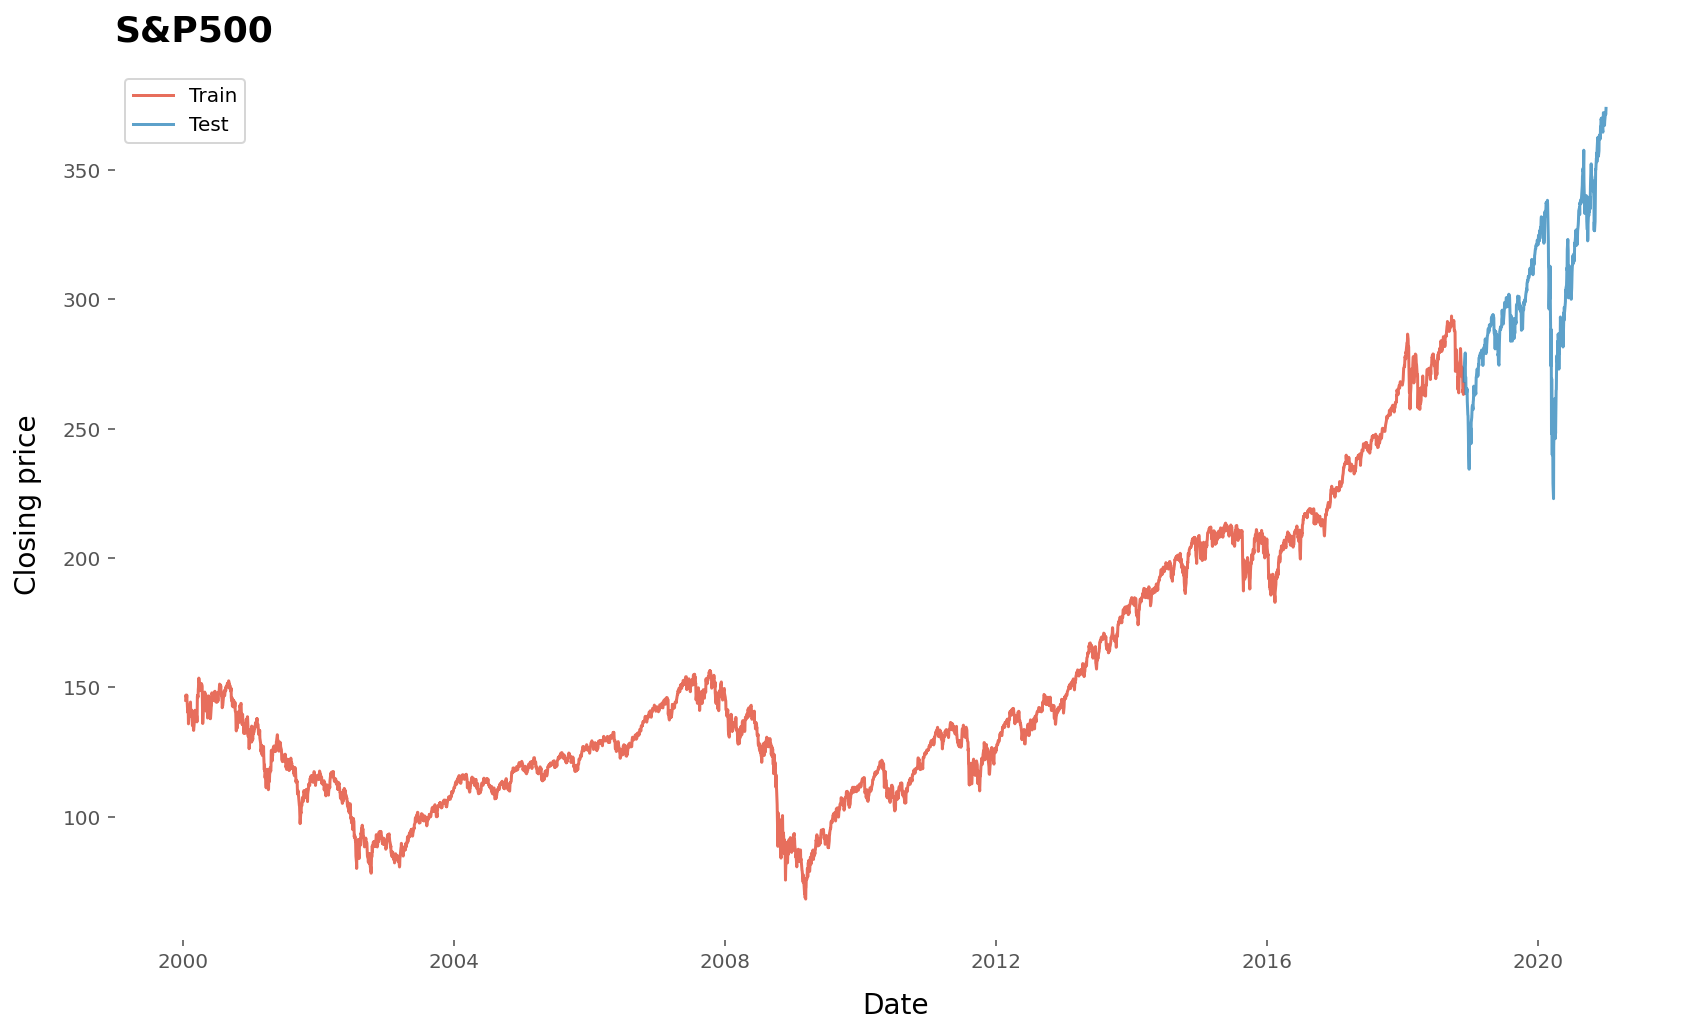

In [86]:
plt.figure(figsize=(14, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index[:train_size+val_size], 
         df['Close'][:train_size+val_size], 
         label='Train', alpha=0.8)

plt.plot(df.index[train_size+val_size:], 
         df['Close'][train_size+val_size:], 
         label='Test', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

## Models

In [87]:
def get_predictions(model, scaler, X_train, y_train, X_test, y_test):
    model.eval()
    y_pred_train = model(X_train.to(device))
    y_pred_test = model(X_test.to(device))

    y_pred_train = scaler.inverse_transform(y_pred_train.cpu().detach().numpy())
    y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
    
    y_pred_test = scaler.inverse_transform(y_pred_test.cpu().detach().numpy())
    y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

    return y_pred_train, y_train, y_pred_test, y_test

In [89]:
def eval_losses(y_pred_train, y_true_train, y_pred_test, y_true_test):
    print(f'Train RMSE = {np.sqrt(sum((y_pred_train - y_true_train) ** 2))[0]:.5}')
    print(f'Train MAE = {sum(np.abs(y_pred_train - y_true_train))[0]:.5}')
    smape_train = 100 / len(y_pred_train) * np.sum(2 * np.abs(y_pred_train - y_true_train) / (np.abs(y_pred_train) + np.abs(y_true_train)))
    print(f'Train SMAPE = {smape_train:.5}\n')

    print(f'Test RMSE = {np.sqrt(sum((y_pred_test - y_true_test) ** 2))[0]:.5}')
    print(f'Test MAE = {sum(np.abs(y_pred_test - y_true_test))[0]:.7}')
    smape_test = 100 / len(y_pred_test) * np.sum(2 * np.abs(y_pred_test - y_true_test) / (np.abs(y_pred_test) + np.abs(y_true_test)))
    print(f'Test SMAPE = {smape_test:.5}')

    print(f'R_sq = {r2_score(y_true_test, y_pred_test)}')

In [90]:
class RMSELoss(nn.Module):
    def __init__(self, reduction):
        super().__init__()
        self.mse = nn.MSELoss(reduction=reduction)
        
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [91]:
criterion = RMSELoss(reduction='mean')

## RNNs

A recurrent neural network (RNN) is a type of the ANN that is well-suited to time series $\{y_t\}_{t=1}^T$, since it is designed to work with sequence data.

![](Stock-Price-Forecasting/images/rnn_1.svg)


Let us assume that we want to maximize the probability of a series $\{y_t\}_{t=1}^T$. Then the model would be written as 
$$
 p(y_1, \dots, y_T) = \prod_{t=1}^{T}p(y_t \mid y_{t-1}, \dots, y_1) \rightarrow \max 
$$

In order to get $\hat y_t$, there is a need to model the conditional probability given all previous values $\hat y_{t-1}, \dots, \hat y_1$:

$$
\hat y_t \sim p(y_t \mid \hat y_{t-1}, \dots, \hat y_1)
$$

Note that to get the probability of $y_t$ we need to construct $t-1$
sequential models. In such a case, the memory requirements grow exponentially with the time step $t$.

However, instead of modeling this probability, we could use a latent variable $h_t$ called a hidden state, which stores all data it has seen so far:

$$
p(y_t \mid \hat y_{t-1}, \dots, \hat y_1) \approx p(y_t \mid h_{t-1}), \ h_t = f(y_t, h_{t-1})
$$

The RNN uses this technique. It is the ANN with hidden states and is capable of conditioning the model on all previous values. Consider a multivariate time series $\{(x_t, y_t)\}_{t=1}^{T}$, $x_t \in \mathbb{R}^d \ \text{and} \  y_t \in \mathbb{R}$, then the RNN has the following architecture:

$$
\begin{equation*} 
\begin{aligned}
h_{t} = & \ f_{h}( W_{xh} x_{t} +W_{hh} h_{t-1} +b_{h}) \\
\hat{y}_{t} = & \ f_{y}( W_{hy} h_{t} +b_{y}) 
\end{aligned}
\end{equation*} 
$$

where $h_{t}$ is hidden state and $\hat y_t$ is output layer at the time step $t$, $W_{xh}$, $W_{hh}$, $W_{hy}$ are weights, $b_{h}, b_{y}$ are biases, and $f_{h}, f_{y}$ are activation functions.

![](images/rnn_2.svg)

### Backpropagation Through Time

To train a RNN model, we use backpropagation through time (BPTT), considering that now $L(y_{t}, \hat{y}( x_{t}; w))=\sum\limits_{t=1}^{T} L_t(y_{t}, \hat{y}_t( x_{t}; w))$.

The derivatives of the loss function when there are no recurrent loops are computed straightforward:
$
\begin{equation*} 
\begin{aligned}
\dfrac{\partial L}{\partial b_{y}} = & \  \sum _{i=t}^{T}\dfrac{\partial L_{t}}{\partial b_{y}} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial b_{y}} \\
\dfrac{\partial L}{\partial b_{h}} = & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial b_{h}} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial b_{h}}
\dfrac{\partial L}{\partial W_{hy}} = \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial W_{hy}} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial W_{hy}} 
\end{aligned}
\end{equation*} 
$

However, it gets a little bit more complicated when there are recurrent loops. Let $W\in \{W_{xh} ,W_{hh}\}$, then the derivatives of the loss function are written as follows

$$
\begin{equation*} 
\begin{aligned}
\dfrac{\partial L}{\partial W} = & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial W} = \\
= & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial h_{t}}\left(\dfrac{\partial h_{t}}{\partial W} +\dfrac{\partial h_{t}}{\partial h_{t-1}}\dfrac{\partial h_{t-1}}{\partial W} +\dotsc +\dfrac{\partial h_{t}}{\partial h_{t-1}}\dfrac{\partial h_{t-1}}{\partial h_{t-2}} \dotsc \dfrac{\partial h_{1}}{\partial W}\right) = \\
= & \ \sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial \hat{y}_{t}}\dfrac{\partial \hat{y}_{t}}{\partial h_{t}}\sum _{i=1}^{t}\left(\prod _{j=i+1}^{t}\dfrac{\partial h_{j}}{\partial h_{j-1}}\right)\dfrac{\partial h_{t}}{\partial W}
\end{aligned}
\end{equation*} 
$$

Note that because a neuron $h\in \mathbb{R}^{q}$, each $\partial h_{j} /\partial h_{j-1}$ is the Jacobian matrix for $h$:
$$\dfrac{\partial h_{j}}{\partial h_{j-1}} =\left(\dfrac{\partial h_{j}}{\partial h_{j-1,1}} ,\dotsc ,\dfrac{\partial h_{j}}{\partial h_{j-1,q}}\right) =\begin{pmatrix}
\dfrac{\partial h_{j,1}}{\partial h_{j-1,1}} & \dotsc  & \dfrac{\partial h_{j,1}}{\partial h_{j-1,q}}\\
\vdots  & \ddots  & \vdots \\
\dfrac{\partial h_{j,q}}{\partial h_{j-1,1}} & \dotsc  & \dfrac{\partial h_{j,q}}{\partial h_{j-1,q}}
\end{pmatrix}$$

Now it can be inferred that the RNN has vanishing and exploding gradient problems:

1. If $\parallel \dfrac{\partial h_{j}}{\partial h_{j-1}} \parallel _{2} \ < 1$, then the gradient is vanishing as the time step $t$ is becoming large. It means that $W^{new} = W^{old} -\eta _{t}\dfrac{\partial L}{\partial W} \approx W^{old}$. To put it another way, our neural network stops learning.

2. If $\parallel \dfrac{\partial h_{j}}{\partial h_{j-1}} \parallel _{2}  \ >1$, then the gradient is exploding as the time step $t$ is becoming large. Enormous updates to the weight during training reaches a bad parameter configuration and sometimes can cause a numerical overflow, i.e. NaNs.


Given that, the RNN models often need help to stabilize their training. To solve the problem of exploding gradients, Pascanu et al. introduced a simple solution that clips gradients to a small
number whenever they explode: 

$$
    g = \min\left(1, \dfrac{\delta}{ \parallel g \parallel_2}  \right)g
$$

where $\delta$ is the threshold and $g = \dfrac{\partial L}{\partial W}$. Alas, we still have the vanishing gradient problem.

### LSTM

The main problem of the RNN is that it struggles to preserve information over many time steps, since the hidden state is constantly being rewritten $h_t = f_{h}( W_{xh} x_{t} +W_{hh} h_{t-1} +b_{h})$. In order to cope with this, specific gates $\Gamma = f( W_{x} x_{t} +W_{h} h_{t-1} +b)$ are introduced, where $W_{x}, W_{h}, b$ are weights specific to the gate and $f$ is an activation function. 

![](images/lstm.svg)

Hochreiter and Schmidhuber proposed a RNN model with Long-Term Short-Term Memory (LSTM) blocks as a solution to the vanishing gradient problem. The LSTM block is designed to address long-term information preservation and short-term input skipping by using not only a hidden state $h_t$, but also a memory cell $c_t$ which is able to remember information over time. 

It has the following architecture:
1. Hidden state $h_t$ and cell state $c_t$:

$$
\begin{equation*} 
\begin{aligned}
c_{t} = & \ \Gamma _{i} \odot \Gamma _{c} + \Gamma _{f} \odot c_{t-1} \\
h_{t} = & \ \Gamma _{o} \odot \tanh( c_{t})
\end{aligned}
\end{equation*} 
$$


2. Input gate that decides what parts of the new cell content are written to cell

$$
\begin{equation*} 
\begin{aligned}
\Gamma _{i} = & \ \sigma ( W_{xi} x_{t} +W_{hi} h_{t-1} +b_{i})
\end{aligned}
\end{equation*} 
$$

3. Cell gate that decides what new content to be written to the cell

$$
\begin{equation*} 
\begin{aligned}
\Gamma _{c} = & \ \tanh( W_{xc} x_{t} +W_{hc} h_{t-1} +b_{c})
\end{aligned}
\end{equation*} 
$$

   

4. Forget gate that decides what is kept and what is forgotten from previous cell state.

$$
\begin{equation*} 
\begin{aligned}
\Gamma _{f} = & \ \sigma ( W_{xf} x_{t} +W_{hf} h_{t-1} +b_{f})
\end{aligned}
\end{equation*} 
$$


5. Output gate that decides what parts of cell are output to hidden state

$$
\begin{equation*} 
\begin{aligned}
\Gamma _{o} = & \ \sigma ( W_{xo} x_{t} +W_{ho} h_{t-1} +b_{o})
\end{aligned}
\end{equation*} 
$$


Using BPTT, we can show that $\displaystyle \forall W \in \{W_{xi}, W_{hi}, W_{xf}, W_{hf}, W_{xc}, W_{hc}, W_{xo}, W_{ho}\}$ the derivatives of the loss function are written as
$$\dfrac{\partial L}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial c_{t}}\dfrac{\partial c_{t}}{\partial c_{t-1}} \dotsc \dfrac{\partial c_{1}}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial c_{t}}\left(\prod _{j=i+1}^{t}\dfrac{\partial c_{j}}{\partial c_{j-1}}\right)\dfrac{\partial c_{1}}{\partial W}$$

To solve the vanishing or exploding gradient problem, we need $\parallel \dfrac{\partial c_{j}}{\partial c_{j-1}} \parallel _{2} \ \approx 1$. 
So, let us then expand the product expression:

$
\begin{equation*} 
\begin{aligned}
\dfrac{\partial c_{j}}{\partial c_{j-1}} = & \ \dfrac{\partial }{\partial c_{j-1}}( \Gamma _{i} \odot \Gamma _{c} +\Gamma _{f} \odot c_{j-1}) =\dfrac{\partial }{\partial c_{j-1}}( \Gamma _{i} \odot \Gamma _{c}) +\dfrac{\partial }{\partial c_{j-1}}( \Gamma _{f} \odot c_{j-1}) =
\\
= & \ \dfrac{\partial \Gamma _{i}}{\partial c_{j-1}} \Gamma _{c} +\dfrac{\partial \Gamma _{c}}{\partial c_{j-1}} \Gamma _{i} +\dfrac{\partial \Gamma _{f}}{\partial c_{j-1}} c_{j-1} +\Gamma _{f}
\end{aligned}
\end{equation*} 
$

We can observe that LSTM's additive property enables us to balance the gradient values during BPTT:

$$\dfrac{\partial L}{\partial W} =\sum _{t=1}^{T}\dfrac{\partial L_{t}}{\partial h_{t}}\dfrac{\partial h_{t}}{\partial c_{t}}\left(\prod _{j=i+1}^{t}\left[\dfrac{\partial \Gamma _{i}}{\partial c_{j-1}} \Gamma _{c} +\dfrac{\partial \Gamma _{c}}{\partial c_{j-1}} \Gamma _{i} +\dfrac{\partial \Gamma _{f}}{\partial c_{j-1}} c_{j-1} +\Gamma _{f}\right]\right)\dfrac{\partial c_{1}}{\partial W}$$

#### Without Technical Indicators

In [100]:
seed_everything()

lstm_model = LSTM()
lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [101]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

Epoch: 100


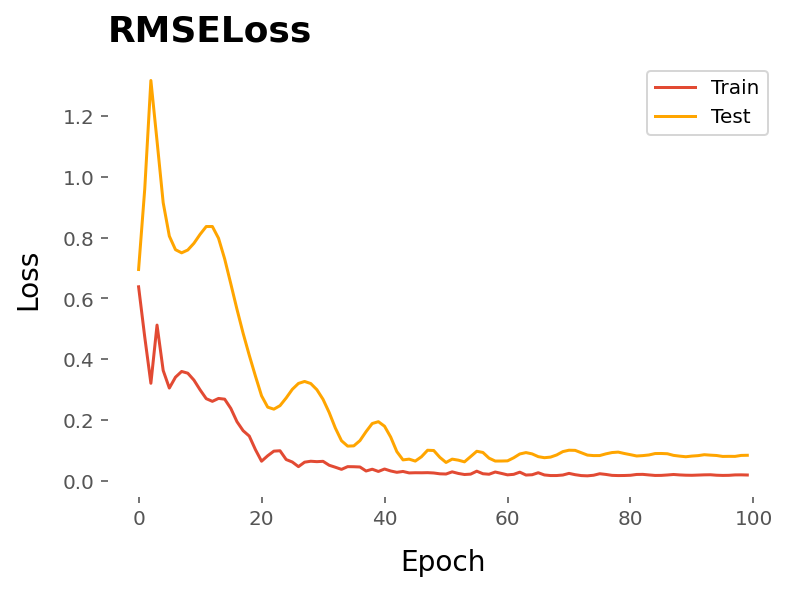

Train loss: 0.01882
Test loss: 0.08372


In [102]:
seed_everything()
train_loss_lstm_without, test_loss_lstm_without = \
    train(lstm_model, criterion, optimizer, device, X_train_without, y_train_without, 
           X_test_without, y_test_without, n_epochs=100)

In [103]:
y_pred_train_lstm_without, y_train_lstm_without, y_pred_test_lstm_without, y_test_lstm_without = \
    get_predictions(lstm_model, scaler_without, X_train_without, y_train_without, X_test_without, y_test_without)

In [104]:
eval_losses(y_pred_train_lstm_without, y_train_lstm_without, 
            y_pred_test_lstm_without, y_test_lstm_without)

Train RMSE = 186.17
Train MAE = 1.0262e+04
Train SMAPE = 1.6093

Test RMSE = 290.18
Test MAE = 4910.607
Test SMAPE = 3.0587
R_sq = 0.817261937301383


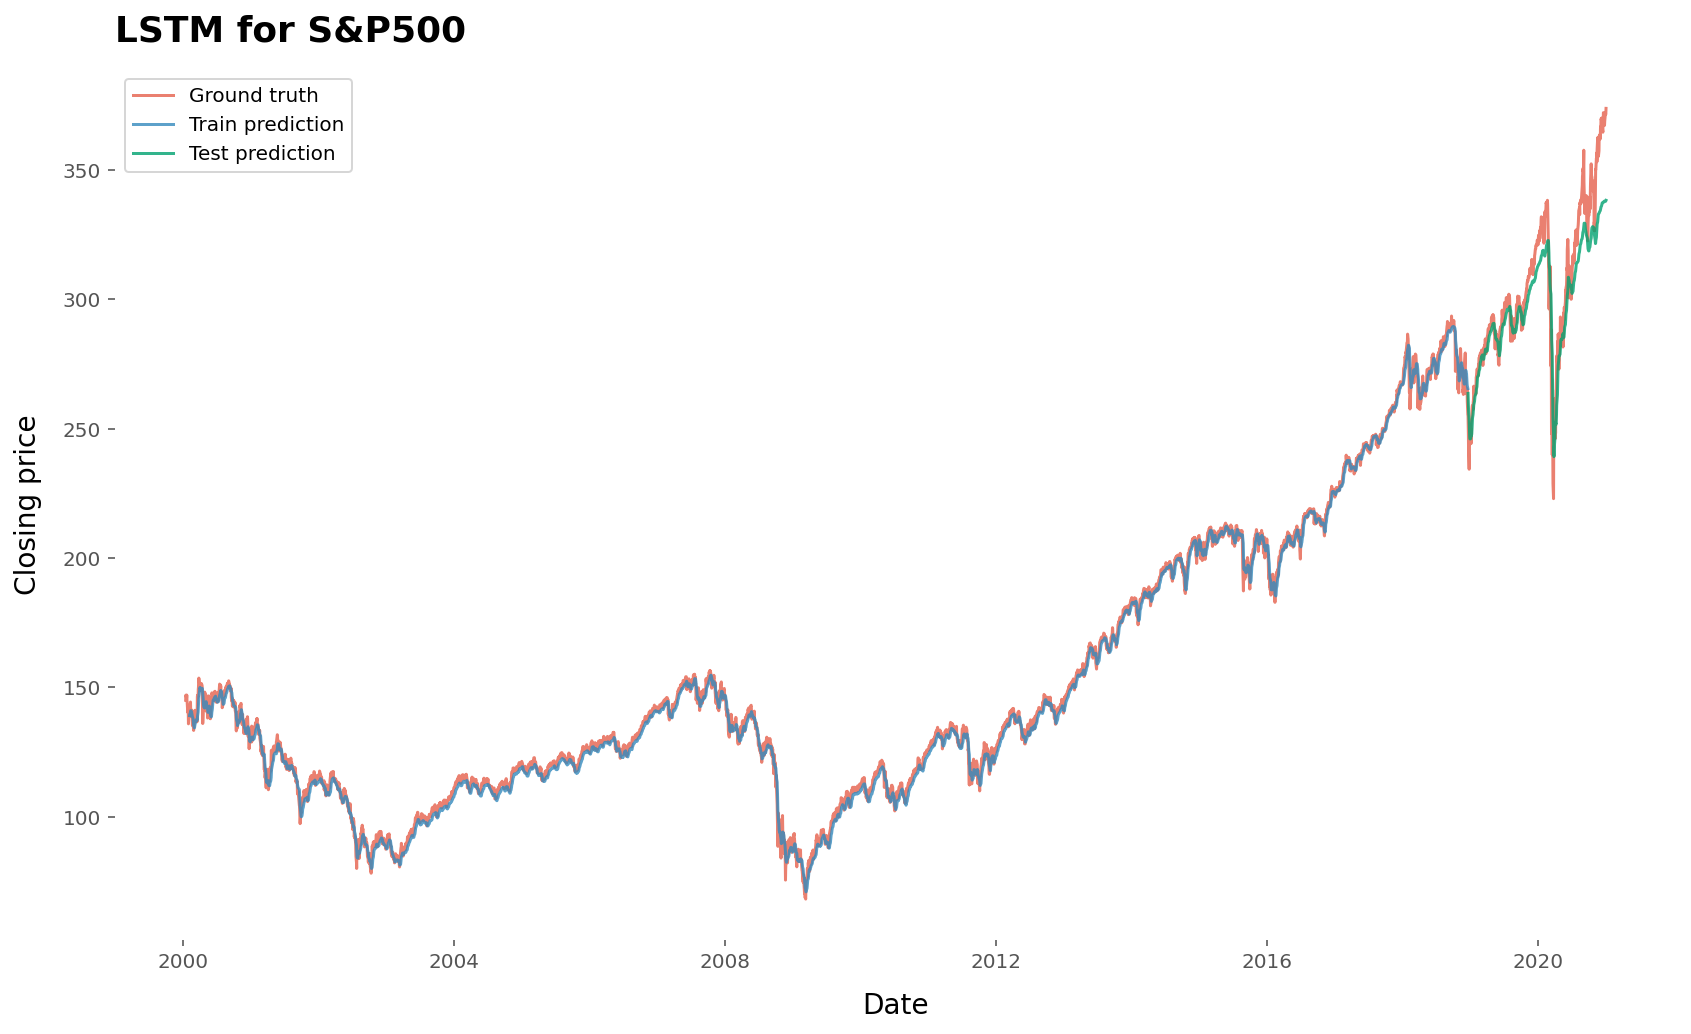

In [105]:
plt.figure(figsize=(14, 8))
plt.title(f'LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.7)

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], 
         y_pred_train_lstm_without.ravel(), 
         label='Train prediction', alpha=0.8)

plt.plot(df.index[val_size+train_size+window_size-1:], 
         y_pred_test_lstm_without.ravel(), 
         label='Test prediction', color='#00A170', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### With Technical Indicators

In [106]:
seed_everything()
lstm_model = LSTM(input_size=X_train_with.shape[2])
lstm_model.to(device)

LSTM(
  (lstm): LSTM(12, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [107]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

Epoch: 100


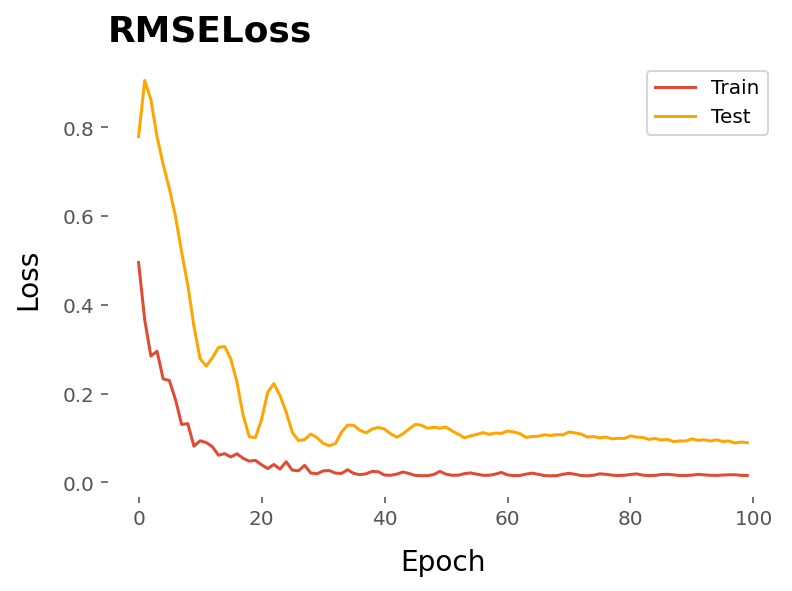

Train loss: 0.01539
Test loss: 0.0895


In [108]:
seed_everything()
train_loss_lstm_with, test_loss_lstm_with = \
    train(lstm_model, criterion, optimizer, device, X_train_with, y_train_without,
          X_test_with, y_test_without, n_epochs=100)

In [109]:
y_pred_train_lstm_with, y_train_lstm_with, y_pred_test_lstm_with, y_test_lstm_with = \
    get_predictions(lstm_model, scaler_without, X_train_with, y_train_with, X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_lstm_with, y_train_lstm_with, y_pred_test_lstm_with, 
            y_test_lstm_with)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'LSTM-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.8)

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], 
         y_pred_train_lstm_with.ravel(), 
         label='Train prediction', alpha=0.8)

plt.plot(df.index[val_size+train_size+window_size-1:], 
         y_pred_test_lstm_with.ravel(), 
         label='Test prediction', color='#9BB7D4', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

### Gated Recurrent Units

Cho et al. proposed in 2014 an alternative to the LSTM. It has only the hidden state $h_{t} =( 1- \Gamma _{u}) \odot \Gamma _{n} +\Gamma _{u} \odot h_{t-1}$ with three gates which offers comparable performance to that of LSTM and is significantly faster to compute:

1. Reset gate:
$$\Gamma _{r} =\sigma ( W_{xr} x_{t} +W_{hr} h_{t-1} +b_{r})$$

2. Update gate: 
$$ \Gamma _{u} =\sigma ( W_{xu} x_{t} +W_{hu} h_{t-1} +b_{u})$$

3. New gate:
$$\Gamma _{n} =\tanh( W_{xn} x_{t} +b_{xn} +\Gamma _{r} \odot  ( W_{hn} h_{t-1} +b_{hn}))$$


![](images/gru.svg)

#### Without Technical Indicators

In [ ]:
seed_everything()
gru_model = GRU()
gru_model.to(device)

In [ ]:
optimizer = optim.Adam(gru_model.parameters(), lr=0.01)

In [ ]:
seed_everything()
train_loss_gru_without, test_loss_gru_without = \
    train(gru_model, criterion, optimizer, device, X_train_without, y_train_without, X_test_without, 
          y_test_without, n_epochs=100)

In [ ]:
y_pred_train_gru_without, y_train_gru_without, y_pred_test_gru_without, y_test_gru_without = \
    get_predictions(gru_model, scaler_without, X_train_without, y_train_without, 
                    X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_gru_without, y_train_gru_without, y_pred_test_gru_without, 
            y_test_gru_without)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'GRU for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.8)

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], 
         y_pred_train_gru_without.ravel(), 
         label='Train prediction', alpha=0.8)

plt.plot(df.index[val_size+train_size+window_size-1:], 
         y_pred_test_gru_without.ravel(), 
         label='Test prediction', color='#EDD59E', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### With Technical Indicators

In [ ]:
seed_everything()
gru_model = GRU(input_size=X_train_with.shape[2])
gru_model.to(device)

In [ ]:
optimizer = optim.Adam(gru_model.parameters(), lr=0.01)

In [ ]:
seed_everything()
train_loss_gru_with, test_loss_gru_with = \
    train(gru_model, criterion, optimizer, device, X_train_with, y_train_with, 
          X_test_with, y_test_with, n_epochs=100)

In [ ]:
y_pred_train_gru_with, y_train_gru_with, y_pred_test_gru_with, y_test_gru_with = \
    get_predictions(gru_model, scaler_without, X_train_with, y_train_with, X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_gru_with, y_train_gru_with, y_pred_test_gru_with, 
            y_test_gru_with)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'GRU-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth', alpha=0.8)

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], 
         y_pred_train_gru_with.ravel(), 
         label='Train prediction', alpha=0.8)

plt.plot(df.index[val_size+train_size+window_size-1:], 
         y_pred_test_gru_with.ravel(), 
         label='Test prediction', color='#6B5876', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### Comparison

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Train RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(train_loss_lstm_without), marker='D', markersize=4, label='LSTM', alpha=0.7, color='#00A170')
plt.plot(np.log(train_loss_lstm_with), marker='o', markersize=4, label='LSTM-TI', alpha=0.7, color='#9BB7D4')
plt.plot(np.log(train_loss_gru_without), marker='^', markersize=4, label='GRU', alpha=0.7, color='#EDD59E')
plt.plot(np.log(train_loss_gru_with), marker='s', markersize=4, label='GRU-TI', alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylim(-4.6, 0.4)

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Test RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(test_loss_lstm_without), marker='D', markersize=4, label='LSTM', alpha=0.7, color='#00A170')
plt.plot(np.log(test_loss_lstm_with), marker='o', markersize=4, label='LSTM-TI', alpha=0.7, color='#9BB7D4')
plt.plot(np.log(test_loss_gru_without), marker='^', markersize=4, label='GRU', alpha=0.7, color='#EDD59E')
plt.plot(np.log(test_loss_gru_with), marker='s', markersize=4, label='GRU-TI', alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylim(-4.6, 0.4)

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);

## Metaheuristic Optimization

Optimal hyperparameters, $\Theta$, of a RNN model that are set before training the neural network, such as a number of neurons and their size, are difficult to determine. Hence, we use a metaheuristic optimization technique to find a good approximation of the global minimum, in contrast to deterministic optimization methods that almost virtually find a local rather than a global optimum solution. 

### Without Technicals

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_without = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_without.fit_transform(data.reshape(-1, 1))).reshape(1, -1).type(torch.Tensor)

In [ ]:
batch_windows = data_preproc.unfold(dimension=-1, size=window_size, step=1).reshape(-1, window_size, 1)
    
X_train_without = batch_windows[:train_size, :-1, :]
X_val_without = batch_windows[train_size:train_size+val_size, :-1]
X_test_without = batch_windows[train_size+val_size:, :-1]

# Need predict the next value considering 14 lookback periods
y_train_without = batch_windows[:train_size, -1, :]
y_val_without = batch_windows[train_size:train_size+val_size, -1, :]
y_test_without = batch_windows[train_size+val_size:, -1, :]

In [ ]:
plt.figure(figsize=(14, 8))
plt.title('S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index[:train_size], 
         df['Close'][:train_size], 
         label='Train', alpha=0.8)

plt.plot(df.index[train_size:train_size+val_size], 
         df['Close'][train_size:train_size+val_size],
         label='Validation', alpha=0.8)

plt.plot(df.index[train_size+val_size:], 
         df['Close'][train_size+val_size:], 
         label='Test', alpha=0.8)

plt.grid(False)
plt.legend()

plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

### With Technicals

In [ ]:
scaler_with = MinMaxScaler(feature_range=(-1, 1))
data_preproc = torch.tensor(scaler_with.fit_transform(df)).type(torch.Tensor)
data_preproc_t = data_preproc.transpose(-2, -1)

windows = []

for i in range(data_preproc.shape[1]):
    windows.append(data_preproc_t.unfold(dimension=-1, size=window_size, step=1)[i].reshape(-1, window_size, 1))

batch_windows = torch.cat((windows), dim=2)

X_train_with = batch_windows[:train_size, :-1, :]
X_val_with = batch_windows[train_size:train_size+val_size, :-1]
X_test_with = batch_windows[train_size+val_size:, :-1]

# Need predict the next value considering 14 lookback periods
y_train_with = y_train_without
y_val_with = y_val_without
y_test_with = y_test_without

In [ ]:
X_val_with = batch_windows[train_size:train_size+val_size, :-1]

### Genetic Algorithm

Genetic algorithm (GA) is a population-based metaheuristic optimization algorithm proposed by Holland (Holland, 1984). The GA imitates the process of natural evolution in solving an optimization problem by relying on biologically inspired operations such as natural selection, mutation, and crossover.

![](images/ga_algorithm.svg)


Let our population $ \Theta$ has $\displaystyle \ell $ individuals with chromosomes $\{\theta_i\}_{i=1}^\ell$, as represented in the first figure, where a chromosome $\theta_i \in \mathbb{R}^p$ is a set of $p$ hyperparameters, and a hyperparameter is called a gene. Then, the population at the time step $\displaystyle k$ is written as follows:
$$ \Theta _{k} =\left\{\theta _{i}^{( k)} \mid \left( \theta _{i1}^{( k)} ,\dotsc ,\theta _{ip}^{( k)]}\right) \in \mathbb{R}^{p}\right\}_{i=1}^{\ell }$$

![](images/ga_population.svg)

Now let us look at the algorithm itself:

1.   We randomly generate the first population of individuals: 
$$\Theta_{0} =\left\{\left(\theta_{1}^{( 0)}, \dotsc, \theta_{\ell}^{( 0)}\right) \in \mathbb{R}^{\ell\times d} \mid \theta _{ij}^{( 0)} \sim U(\alpha, \beta )\right\}$$

2. Then assess the fitness of each individual. For this, we need to calculate the values of the objective function for each chromosome 
$$\mathcal{L}_{k} =\left\{Q\left( \theta _{i}^{( k)}\right)\right\}_{i=1}^{\ell }$$
and apply a transformation function
$$\sigma ( z) =\dfrac{z-\mathcal{L}_{k}^{worst}}{\mathcal{L}_{k}^{best} -\mathcal{L}_{k}^{worst}}$$
such that its components lie between zero and one. For instance, if an individual $z$ has near-one value, it means that it has high fitness relative to other. Hence, we get the values of the fitness function of individuals $ \mathcal {F}_{k} = \left\{\sigma \left(\mathcal {L}_{k}\left(\theta^{(k)}_i\right)\right)\right\}_{i=1}^\ell $.
3. Select the most fitted $m$ individuals for further breeding. For this, we assume that an individual $\xi$ is better fitted than an individual $\eta$ if $\mathcal{F}_{k}(\xi)= \sigma(Q(\xi)) > \sigma(Q(\eta)) = \mathcal{F}_{k}(\eta)$. Then, we rank individuals in the current population according to their fitness values in descending order, that is from the most fitted to the less:
$$\mathcal{F}_{k}^{[ 1]} \geqslant \dotsc \geqslant \mathcal{F}_{k}^{[ m]} \geqslant \dotsc \geqslant \mathcal{F}_{k}^{[ \ell ]}$$

4. Crossover the fittest $m$ individuals with everyone else. This is how we spread the "good" \ genes throughout the population. By crossover we mean the operation of creating a new chromosome, wherein a part of the genes will be from the high fitted individual $\displaystyle \xi ^{( k)} \in \left\{\theta _{i}^{( k)}\right\}_{i=1}^{m}$ with the probability of 
$$\displaystyle \mathbb{P}\left(\left\{ \theta _{i}^{new} =\xi ^{( k)}\right\}\right) =\dfrac{\sigma \left( Q\left( \xi ^{( k)}\right)\right)}{\sigma \left( Q\left( \xi ^{( k)}\right)\right) +\sigma \left( Q\left( \eta ^{( k)}\right)\right)}$$
and of the genes will be from the less fitted individual $\eta ^{( k)} \in \left\{\theta _{i}^{( k)}\right\}_{i=m+1}^{n}$ with the probability of 
$$\mathbb{P}\left(\left\{\theta _{i}^{new} =\eta ^{( k)}\right\}\right) =\dfrac{\sigma \left( Q\left( \eta ^{( k)}\right)\right)}{\sigma \left( Q\left( \xi ^{( k)}\right)\right) +\sigma \left( Q\left( \eta ^{( k)}\right)\right)}$$. 
Thus, we get
$$\theta _{ij}^{new} =\begin{cases} \xi _{j}^{( k)}, & \text{with} \ \mathbb{P}\left(\left\{\theta _{i}^{new} =\xi ^{( k)}\right\}\right)\\ \eta _{j}^{( k)}, & \text{with} \ \mathbb{P}\left(\left\{\theta _{i}^{new} =\eta ^{( k)}\right\}\right) \end{cases} ,\ i\in ( m+1,\dotsc ,n) ,\ j\in ( 1, \dotsc, p)$$

5. All individuals except the best in the current population, $ \left\{\theta _ {i} ^ {(k)} \right \} _ {i = 2} ^ {\ell} $, are mutated. The mutation changes an arbitrary number of genes in an individual's chromosome for other but rather close to the original value, so afterwards we get
$$ \Theta_{k+1} =\left\{\theta _{1}^{( k)}\right\} \cup \left\{\theta _{i}^{( k)} \mid \theta _{ij}^{( k)} =\theta _{ij}^{( k)} +\varepsilon _{j}\right\}_{i=2}^{\ell } $$

6. Go to the step 2 until the stop criterion is met. For instance, it can be a reach of the maximum possible number of population evolutions.

Now, we attempt to choose hyperparameters of our models, that is the correct number of hidden layers and training epochs, the hidden size of neurons, and the learning rate. For this reason, the genetic algorithm is used as a metaheuristic optimizer. Hence, we create a population with $150$ individuals—in our case, Adam optimized neural networks—with the mutation rate of $40\%$ and $10$ meta epochs considered. Moreover, we select the $40$ most fitted individuals to crossover. 


![](images/ga_rnn.svg)



Given that a number of hidden layers can range from $1$ to $15$, training epochs from $60$ to $300$, a hidden size from $8$ to $512$, and a learning rate from $0.001$ to $1$.

#### GA-LSTM

In [ ]:
seed_everything()
# Here k is NOT a time step but m in the equations above! (Sorry about that)
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='LSTM',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

In [ ]:
ga_optimizer.fit(X_val_without, y_val_without)

In [ ]:
seed_everything()
ga_lstm_model = LSTM(input_size=X_train_without.shape[2],
                     hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                     num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_lstm_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(ga_lstm_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

In [ ]:
seed_everything()
train_loss_ga_lstm_without, test_loss_ga_lstm_without = \
    train(ga_lstm_model, criterion, optimizer, device, 
          torch.vstack((X_train_without, X_val_without)), 
          torch.vstack((y_train_without, y_val_without)), 
          X_test_without, y_test_without, 
          n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [ ]:
y_pred_train_ga_lstm_without, y_train, y_pred_test_ga_lstm_without, y_test = \
    get_predictions(ga_lstm_model, scaler_without, 
                    torch.vstack((X_train_without, X_val_without)),
                    torch.vstack((y_train_without, y_val_without)), 
                    X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_ga_lstm_without, y_train, 
            y_pred_test_ga_lstm_without, y_test)

In [ ]:
plt.figure(figsize=(14, 6))
plt.title(f'GA-LSTM for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_lstm_without.ravel(), label='Train prediction', alpha=0.8)
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_lstm_without.ravel(), label='Test prediction', color='#00A170', alpha=0.8)

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### GA-LSTM-TI

In [ ]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='LSTM',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

In [ ]:
ga_optimizer.fit(X_val_with, y_val_with)

In [ ]:
seed_everything()
ga_lstm_model = LSTM(input_size=X_train_with.shape[2],
                     hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                     num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_lstm_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(ga_lstm_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

In [ ]:
seed_everything()
train_loss_ga_lstm_with, test_loss_ga_lstm_with = \
    train(ga_lstm_model, criterion, optimizer, device, 
          torch.vstack((X_train_with, X_val_with)), 
          torch.vstack((y_train_with, y_val_with)), 
          X_test_with, y_test_with, 
          n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [ ]:
y_pred_train_ga_lstm_with, y_train, y_pred_test_ga_lstm_with, y_test = \
    get_predictions(ga_lstm_model, scaler_without, 
                    torch.vstack((X_train_with, X_val_with)),
                    torch.vstack((y_train_with, y_val_with)), 
                    X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_ga_lstm_with, y_train, 
            y_pred_test_ga_lstm_with, y_test)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'GA-LSTM-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')
plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], y_pred_train_ga_lstm_with.ravel(), label='Train prediction')
plt.plot(df.index[val_size+train_size+window_size-1:], y_pred_test_ga_lstm_with.ravel(), label='Test prediction', color='#9BB7D4')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### GA-GRU

In [ ]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='GRU',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

In [ ]:
ga_optimizer.fit(X_val_without, y_val_without)

In [ ]:
seed_everything()
ga_gru_model = GRU(input_size=X_train_without.shape[2],
                    hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                    num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_gru_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(ga_gru_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

In [ ]:
seed_everything()
train_loss_ga_gru_without, test_loss_ga_gru_without = \
    train(ga_gru_model, criterion, optimizer, device, 
          torch.vstack((X_train_without, X_val_without)), 
          torch.vstack((y_train_without, y_val_without)), 
          X_test_without, y_test_without,
          n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [ ]:
y_pred_train_ga_gru_without, y_train, y_pred_test_ga_gru_without, y_test = \
    get_predictions(ga_gru_model, scaler_without, 
                    torch.vstack((X_train_without, X_val_without)),
                    torch.vstack((y_train_without, y_val_without)), 
                    X_test_without, y_test_without)

In [ ]:
eval_losses(y_pred_train_ga_gru_without, y_train, 
            y_pred_test_ga_gru_without, y_test)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'GA-GRU for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], 
         y_pred_train_ga_gru_without.ravel(), 
         label='Train prediction')

plt.plot(df.index[val_size+train_size+window_size-1:], 
         y_pred_test_ga_gru_without.ravel(), 
         label='Test prediction', color='#EDD59E')

plt.legend()
plt.grid(False)
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

#### GA-GRU-TI

In [ ]:
seed_everything()
config = GeneticAlgorithmConfig(ell=150, k=40, num_epochs=10, mutation_rate=0.4)
population = Population(config)

In [ ]:
ga_optimizer = GeneticAlgorithm(optimized_block='GRU',criterion=criterion, 
                                population=population, config=config, 
                                device=device, verbose=True)

In [ ]:
ga_optimizer.fit(X_val_with, y_val_with)

In [ ]:
seed_everything()
ga_gru_model = GRU(input_size=X_train_with.shape[2],
                   hidden_size=ga_optimizer.population.best_indivdual.hidden_size,
                   num_layers=ga_optimizer.population.best_indivdual.num_layers)
ga_gru_model.to(device)

In [ ]:
optimizer = torch.optim.Adam(ga_gru_model.parameters(), 
                             lr=ga_optimizer.population.best_indivdual.learning_rate)

In [ ]:
seed_everything()
train_loss_ga_gru_with, test_loss_ga_gru_with = \
    train(ga_gru_model, criterion, optimizer, device,
          torch.vstack((X_train_with, X_val_with)), 
          torch.vstack((y_train_with, y_val_with)), 
          X_test_with, y_test_with,
          n_epochs=ga_optimizer.population.best_indivdual.num_epochs_base)

In [ ]:
y_pred_train_ga_gru_with, y_train, y_pred_test_ga_gru_with, y_test = \
    get_predictions(ga_gru_model, scaler_without, 
                    torch.vstack((X_train_with, X_val_with)),
                    torch.vstack((y_train_with, y_val_with)), 
                    X_test_with, y_test_with)

In [ ]:
eval_losses(y_pred_train_ga_gru_with, y_train, 
            y_pred_test_ga_gru_with, y_test)

In [ ]:
plt.figure(figsize=(14, 8))
plt.title(f'GA-GRU-TI for S&P500', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(df.index, df['Close'], label='Ground truth')

plt.plot(df.index[window_size-1:val_size+train_size+window_size-1], 
         y_pred_train_ga_gru_with.ravel(), 
         label='Train prediction')

plt.plot(df.index[val_size+train_size+window_size-1:], 
         y_pred_test_ga_gru_with.ravel(), 
         label='Test prediction', color='#6B5876')

plt.grid(False)
plt.legend()
plt.xlabel('Date', labelpad=10, fontsize=14)
plt.ylabel('Closing price', labelpad=10, fontsize=14);

In [ ]:
plt.figure(figsize=(14, 8))
plt.title('Train RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(train_loss_ga_lstm_without), 
         marker='D', markersize=4, label='GA-LSTM', 
         alpha=0.7, color='#00A170')

plt.plot(np.log(train_loss_ga_lstm_with), 
         marker='o', markersize=4, label='GA-LSTM-TI', 
         alpha=0.7, color='#9BB7D4')

plt.plot(np.log(train_loss_ga_gru_without), 
         marker='^', markersize=4, label='GA-GRU', 
         alpha=0.7, color='#EDD59E')

plt.plot(np.log(train_loss_ga_gru_with), 
         marker='s', markersize=4, label='GA-GRU-TI', 
         alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);

In [ ]:
plt.figure(figsize=(14, 8))
plt.title('Test RMSE', pad=14, fontsize=18, loc='left', fontweight='bold')

plt.plot(np.log(test_loss_ga_lstm_without), 
         marker='D', markersize=4, label='GA-LSTM', 

         alpha=0.7, color='#00A170')
plt.plot(np.log(test_loss_ga_lstm_with), 
         marker='o', markersize=4, label='GA-LSTM-TI', 
         alpha=0.7, color='#9BB7D4')

plt.plot(np.log(test_loss_ga_gru_without), 
         marker='^', markersize=4, label='GA-GRU', 
         alpha=0.7, color='#EDD59E')

plt.plot(np.log(test_loss_ga_gru_with), 
         marker='s', markersize=4, label='GA-GRU-TI', 
         alpha=0.7, color='#6B5876')

plt.grid(False)
plt.legend()

plt.ylabel('Loss, log scaled', labelpad=10, fontsize=14)
plt.xlabel('Epoch', labelpad=10, fontsize=14);